In [1]:
import numpy as np
import imageio as imio
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.filters import try_all_threshold as tat
from skimage.filters import threshold_otsu as otsu
from skimage.morphology import remove_small_objects as rso
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from sklearn import preprocessing
from scipy import ndimage as ndi
import nibabel as nib
from scipy.stats import pearsonr
import os
from skimage.feature import match_template
import math
from statistics import mode

/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Functions

In [2]:
def plot_img(img):
    """ plots the raw weight matrices and the standardized wt. matrices """
    f = plt.figure()
    n_ = imio.imread('./neuron_{}.png'.format(img))[:,:,0]  
#     ax1 = plt.subplot(121)
#     ax1.set_title('raw image')
#     plt.imshow(n_, cmap='gray')
    n = n_.astype(float)
    n = (n - np.mean(n)) / np.std(n)
    ax2 = plt.subplot(121)
    ax2.set_title('stdized')
    plt.imshow(n, cmap='gray')
    return n

In [3]:
def cmpnt_tc(data, sm_dict):
    """ reconstructs a time course for each ground truth component """
    print(data.shape)
    sm_mtrx = []
#     print(sorted(list([int(i) for i in sm_dict.keys()])))
    print(sm_dict.keys())
    for sm in range(1,len(sm_dict.keys())+1):
        sm_arr = np.reshape(sm_dict[str(sm)], (16384))
        sm_mtrx.append(sm_arr)
    sm_matrix = np.asarray(sm_mtrx)
    print(sm_matrix.shape)
    sm_tc = np.matmul(sm_matrix,np.transpose(data))
    print(sm_tc.shape)
    return sm_tc

In [4]:
def spat_corr(sm_est, sm_gt, max_only=True, pos_th=0.6, neg_th=-0.6):
    """ 
    Determines the spatial correlations for all weight matrices againsts each ground truth component.
    
    Either picks the maximum correlation pair for each ground truth componen; 
    or all matches above/below the given thresholds.
    
    """
#     sim_sm = list([sm_gt+i for i in os.listdir(sm_gt) if i.endswith('.nii')])
    sim_sm = sorted(list([sm_gt+i for i in os.listdir(sm_gt) if i.endswith('.nii')]), key= lambda x: int(x.split('/')[-1].split('.')[0]))
    pos_sc = {}
    neg_sc = {}
    sm = {}
    spat_corrs = {}
    for n in range(1,129):
        wt = 'neuron_{}'.format(n)
        est_sm = sm_est.get(wt)
        n_sc = {}
        for nii in sim_sm:
            gt = nii.split('/')[-1].split('.')[0]
#             if int(gt) < 10: gt = '0{}'.format(gt)
            gt_sm_ = nib.load(nii)
            gt_sm = gt_sm_.get_fdata()
            sm[gt]=gt_sm
#             print(gt_sm.shape)
            sc = pearsonr(np.ravel(est_sm), np.ravel(gt_sm))[0]
            n_sc[gt] = sc
            if not max_only: 
                if any((v>=pos_th or v<=neg_th) for k,v in n_sc.items()):
                    spat_corrs[wt+'__sm_{}'.format(gt)] = sc    
        max_sc = max(n_sc, key=lambda key: n_sc[key])
        min_sc = min(n_sc, key=lambda key: n_sc[key])
        pos_sc[wt+'__sm_{}'.format(max_sc)] = n_sc[max_sc]
        neg_sc[wt+'__sm_{}'.format(min_sc)] = n_sc[min_sc]                    
    if not max_only: return spat_corrs, sm
    else: return pos_sc, neg_sc, sm

In [5]:
def temp_corr(tc_est, tc_gt, max_only=True, pos_th=0.6, neg_th=-0.6):
    """ 
    Finds the temporal correlation between each weight matrix's reconstructed time course and each 
    ground truth's reconstructed time course.
    
    Returns either the maximum match for each ground truth or all matches above/below the thresholds."""
    pos_tc={}
    neg_tc={}
    temp_corrs={}
    for tct in range(len(tc_gt)):
#         print(tc_est[tce].shape)
        e_tcorr = {}
        for tce in range(len(tc_est)):
#             print(tc_gt[tct].shape)
            tempcorr = pearsonr(tc_gt[tct], tc_est[tce])[0]
            e_tcorr[str(tce)] = tempcorr
#             print('estim. tc {} and gt tc {}: corr={}'.format(tce,tct,tempcorr))
            if not max_only: 
                if any((v>=pos_th or v<=neg_th) for k,v in e_tcorr.items()):
                    temp_corrs['neuron_{}__sm_{}'.format(tce+1,tct+1)] = tempcorr  
        max_tcorr = max(e_tcorr, key=lambda key: e_tcorr[key])
        min_tcorr = min(e_tcorr, key=lambda key: e_tcorr[key])
        pos_tc['neuron_{}__gt_{}'.format(int(max_tcorr)+1,tct+1)] = e_tcorr[max_tcorr]
        neg_tc['neuron_{}__gt_{}'.format(int(min_tcorr)+1,tct+1)] = e_tcorr[min_tcorr]
    if not max_only: return temp_corrs
    else: return pos_tc, neg_tc

In [6]:
def plot_temp_corr(temp_corr_pos, temp_corr_neg, wt_tc, gt_tc, wt_dict, gt_dict, pos_th, neg_th):
    """ plots the temporally matched weight matrices and ground truth component maps """
    strong_temp_corrs={}
    for k,v in temp_corr_pos.items():
        if v>pos_th:
            f = plt.figure()
            f.suptitle('{} corr={}'.format(k,v))
            ax = plt.subplot(121)
            ax.set_title(k.split('__')[0])
            plt.imshow(wt_dict[k.split('__')[0]], cmap='gray')
            ax1 = plt.subplot(122)
            ax1.set_title(k.split('__')[1])
            plt.imshow(gt_dict[k.split('_')[-1]], cmap='gray')
            strong_temp_corrs[k]=v
            
            f1 = plt.figure(figsize=(15,12))
            ax = plt.subplot(311)
            ax.set_title(k.split('__')[0])
            plt.plot(wt_tc[int(k.split('__')[0].split('_')[1])-1])
            ax2 = plt.subplot(312)
            ax2.set_title(k.split('__')[1])
            plt.plot(gt_tc[int(k.split('_')[-1])-1])
            ax3 = plt.subplot(313)
            plt.plot(wt_tc[int(k.split('__')[0].split('_')[1])-1])
            plt.plot(gt_tc[int(k.split('_')[-1])-1])
    for k,v in temp_corr_neg.items():
        if v<neg_th:
            f = plt.figure()
            f.suptitle('{} corr={}'.format(k,v))
            ax = plt.subplot(121)
            ax.set_title(k.split('__')[0])
            plt.imshow(wt_dict[k.split('__')[0]], cmap='gray')
            ax1 = plt.subplot(122)
            ax1.set_title(k.split('__')[1])
            plt.imshow(gt_dict[k.split('_')[-1]], cmap='gray')
            strong_temp_corrs[k]=v
            
            f1 = plt.figure(figsize=(15,12))
            ax = plt.subplot(311)
            ax.set_title(k.split('__')[0])
            plt.plot(wt_tc[int(k.split('__')[0].split('_')[1])-1])
            ax2 = plt.subplot(312)
            ax2.set_title(k.split('__')[1])
            plt.plot(gt_tc[int(k.split('_')[-1])-1])
            ax3 = plt.subplot(313)
            plt.plot(wt_tc[int(k.split('__')[0].split('_')[1])-1])
            plt.plot(gt_tc[int(k.split('_')[-1])-1])
    return strong_temp_corrs

In [7]:
def plot_sm_fnc(spat_corr_dict, wt_dict):
    """ 
    For each weight matrix having at least one spatial correlation match 
    greater than the designated thresholds - see spat_corr() - 
    plots a bar graph showing component-wise spatial correlations. 
    
    This is for identifying functional connectivity detections among the weight matrices
    
    """
    for wt in range(1,129):
        wt_sc = []
        for k,v in spat_corr_dict.items():
            if k.split('__')[0] == 'neuron_{}'.format(wt):# and (v>=pos_th or v<=neg_th):
                wt_sc.append([k.split('__')[1],v])#
#         print(wt_sc)
        wt_sc_sorted = sorted(wt_sc,key=lambda x: int(x[0].split('_')[1]))
#         print(wt_sc_sorted)
        if wt_sc:
            f = plt.figure(figsize=(12.8,4.8))
            f.suptitle('Wt matrix {}'.format(wt))
            plt.xticks(range(1,28))
            ax = plt.bar(list(int(wt_sc_sorted[i][0].split('_')[1]) for i in range(len(wt_sc_sorted))),\
                        list(wt_sc_sorted[ii][1] for ii in range(len(wt_sc_sorted))))
#         plt.imshow(ax)

In [8]:
def extract_subjects(tc, num_subjects=20, start=0):
    avg_mtrx = []
    for cmpnt in tc:
        avg_tc = []
        for ts in range(start,int(len(cmpnt)/num_subjects)):
            avg_ts=0
            for sub in range(num_subjects):
                avg_ts+=cmpnt[ts+(int(len(cmpnt)/num_subjects))*sub]
            avg_tc.append(avg_ts/num_subjects)
        avg_mtrx.append(avg_tc)
    return avg_mtrx

## Load the reconstructed time courses
##### Reconstruction performed on original machine the RBM was run on 

In [17]:
sim_tc = np.load('./timecourses.npy')
sim_tc.shape

(128, 8000)

In [18]:
# # not needed
# subject_tc = np.asarray([sim_tc[:,ts:ts+400] for ts in range(0,sim_tc.shape[1],400)])
# subject_tc.shape

#### Load the raw data

In [19]:
gt_tc = np.load('./simtb_masked_stdz.npy')
gt_tc.shape

(8000, 16384)

### Reconstruct the component-wise time courses

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


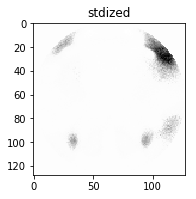

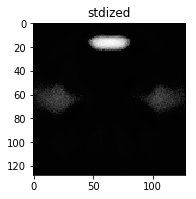

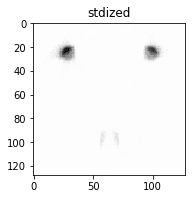

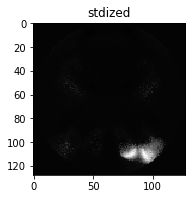

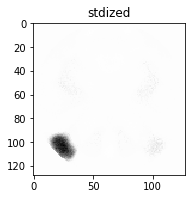

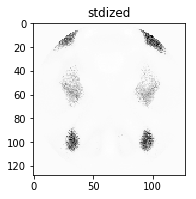

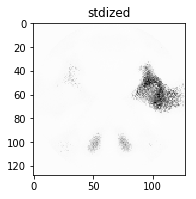

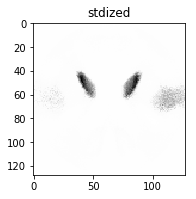

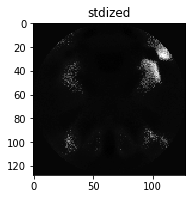

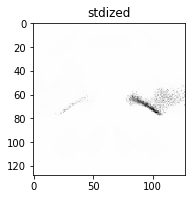

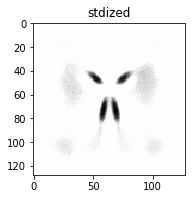

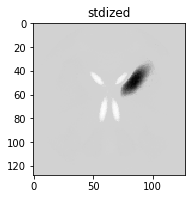

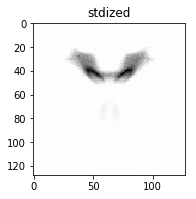

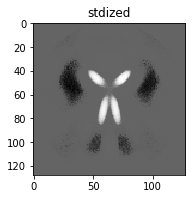

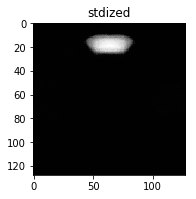

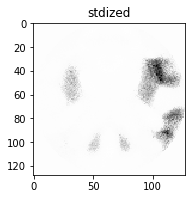

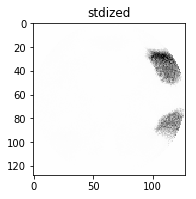

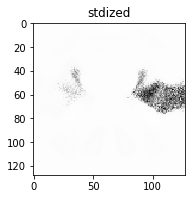

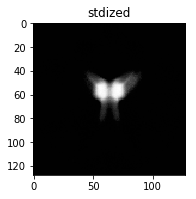

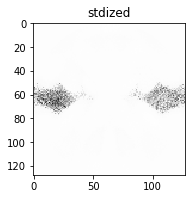

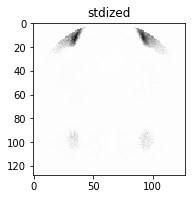

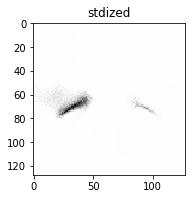

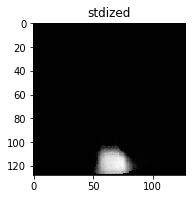

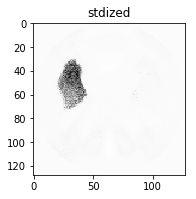

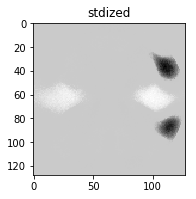

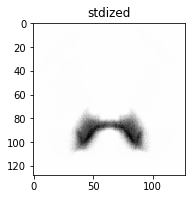

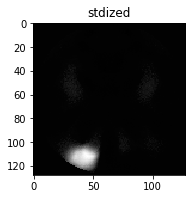

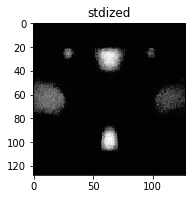

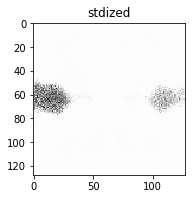

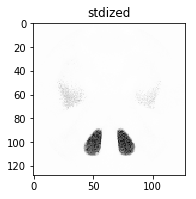

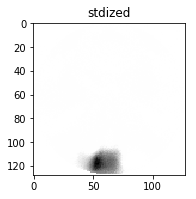

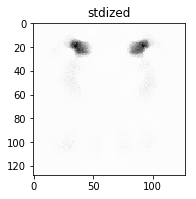

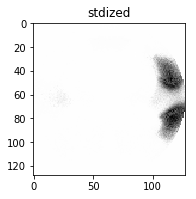

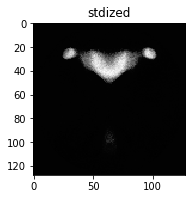

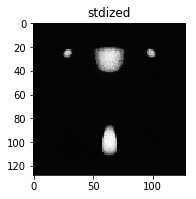

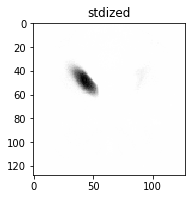

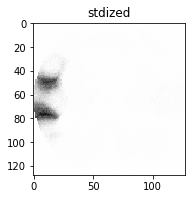

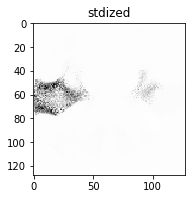

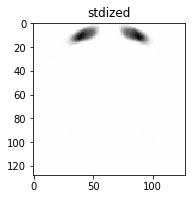

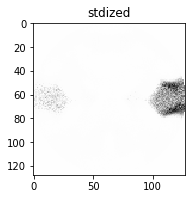

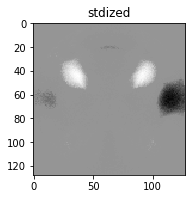

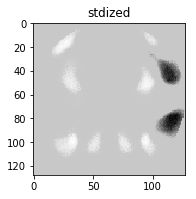

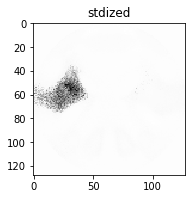

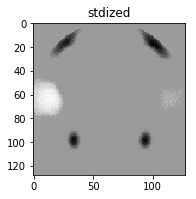

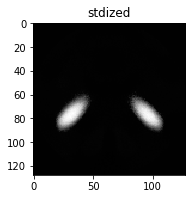

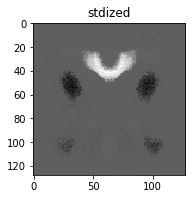

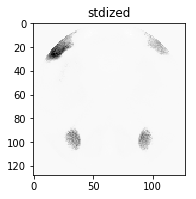

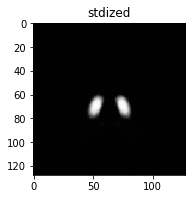

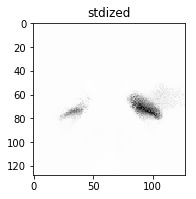

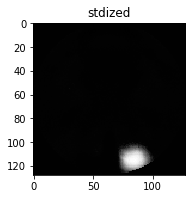

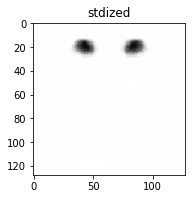

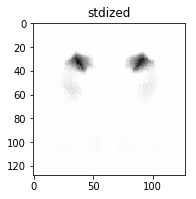

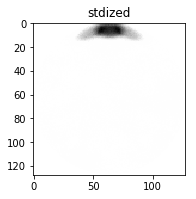

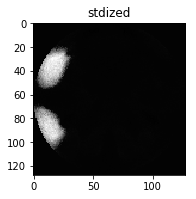

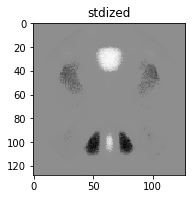

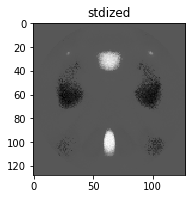

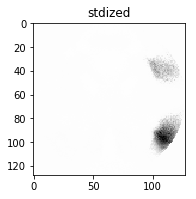

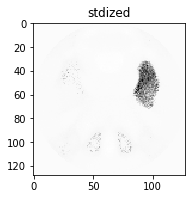

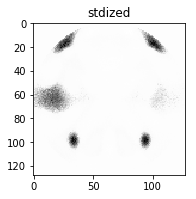

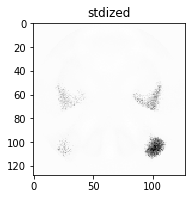

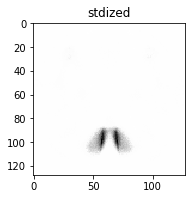

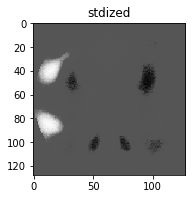

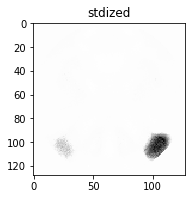

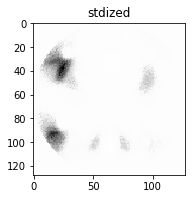

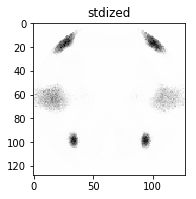

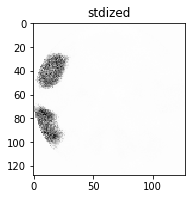

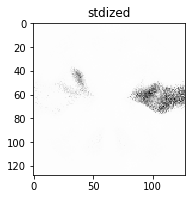

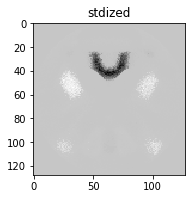

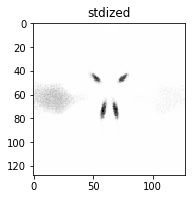

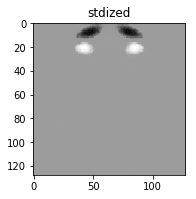

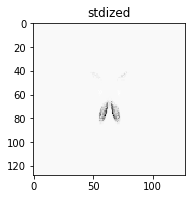

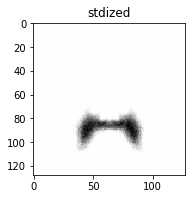

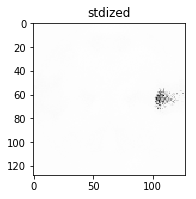

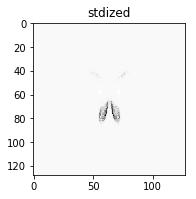

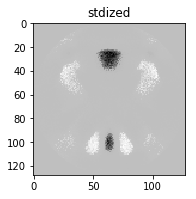

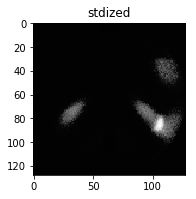

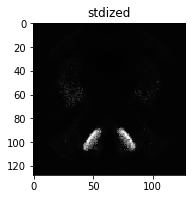

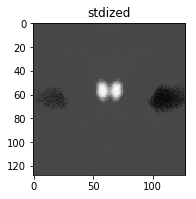

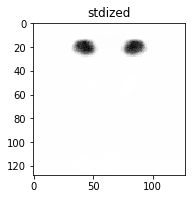

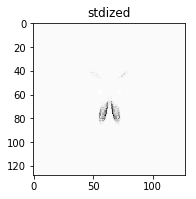

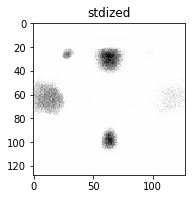

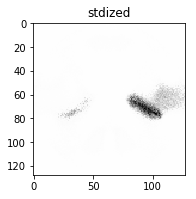

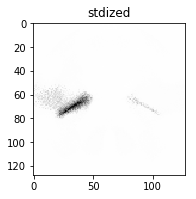

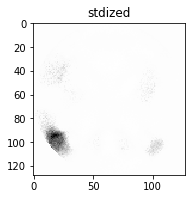

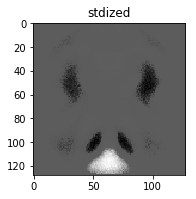

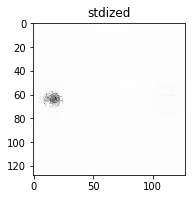

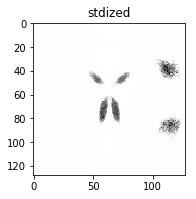

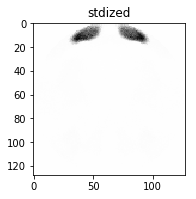

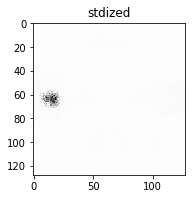

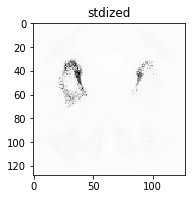

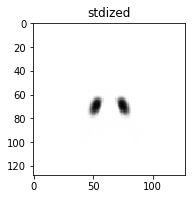

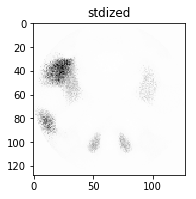

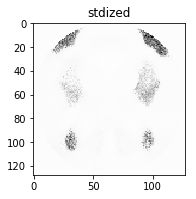

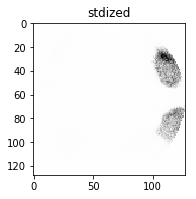

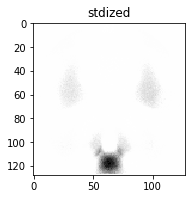

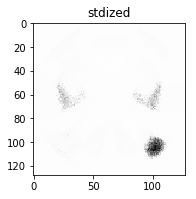

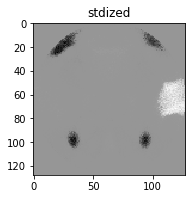

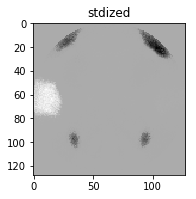

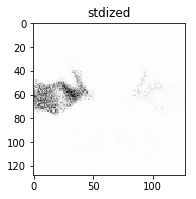

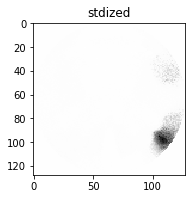

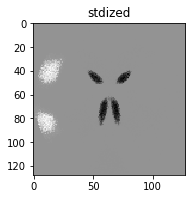

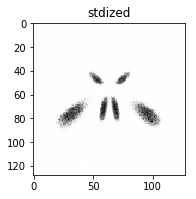

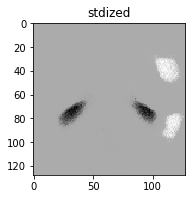

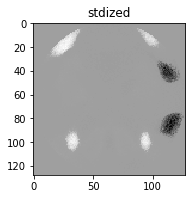

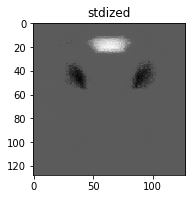

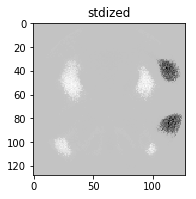

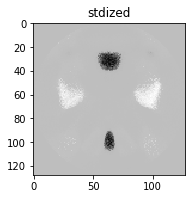

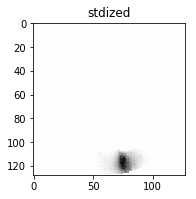

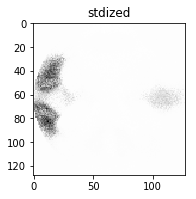

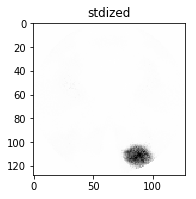

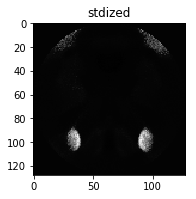

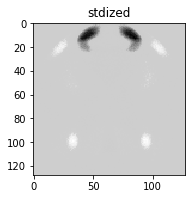

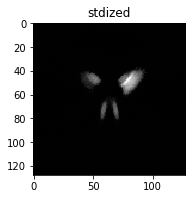

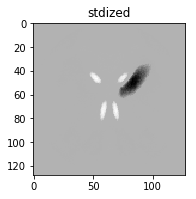

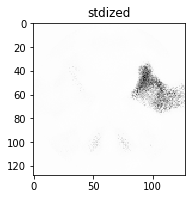

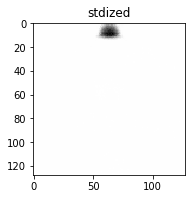

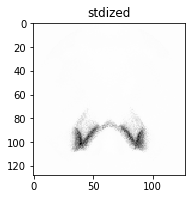

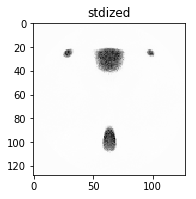

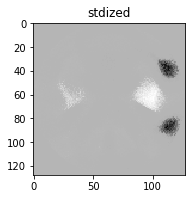

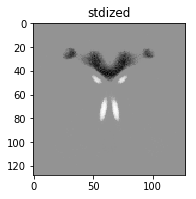

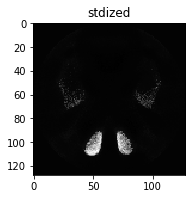

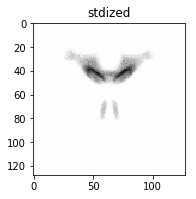

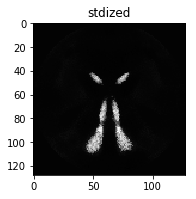

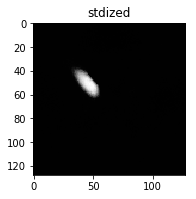

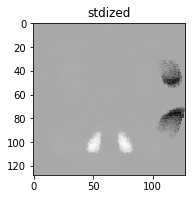

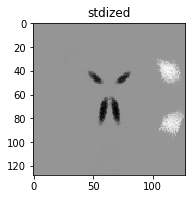

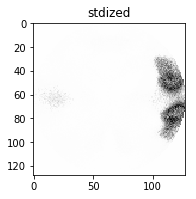

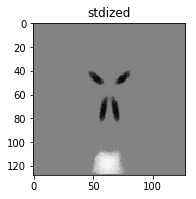

In [9]:
wts_stdz1 = {}
for img in range(1,129):
    n_stdz = plot_img(img)
    wts_stdz1['neuron_{}'.format(img)] = n_stdz

In [10]:
# print(list(wts_stdz.keys()))
wts_stdz2 = sorted(wts_stdz1.items(), key=lambda kv: int(kv[0].split('_')[1]))
wts_stdz = {kv1[0]:kv1[1] for kv1 in wts_stdz2}

In [11]:
gt_cmpnts = '../../sim_SM/' # path to ground truth components

In [23]:
sc_pos, sc_neg, sm_cmpnts = spat_corr(wts_stdz, gt_cmpnts)

In [24]:
sm_tc = cmpnt_tc(gt_tc,sm_cmpnts)

(8000, 16384)
dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27'])
(27, 16384)
(27, 8000)


In [25]:
avg_gt = np.asarray(extract_subjects(sm_tc))
avg_wt = np.asarray(extract_subjects(sim_tc))
print(avg_gt.shape)
print(avg_wt.shape)

(27, 400)
(128, 400)


In [26]:
stdz_gt = preprocessing.scale(np.asarray(extract_subjects(sm_tc)), axis=1)
stdz_wt = preprocessing.scale(np.asarray(extract_subjects(sim_tc)), axis=1)
print(stdz_gt.shape)
print(stdz_wt.shape)

(27, 400)
(128, 400)


In [27]:
delay_gt = preprocessing.scale(np.asarray(extract_subjects(sm_tc, start=10)), axis=1)
delay_wt = preprocessing.scale(np.asarray(extract_subjects(sim_tc, start=10)), axis=1)
print(delay_gt.shape)
print(delay_wt.shape)

(27, 390)
(128, 390)


### Calculate the temporal correlations

In [28]:
pos_tcorrs, neg_tcorrs = temp_corr(sim_tc, sm_tc)

In [29]:
avg_pos_tcorrs, avg_neg_tcorrs = temp_corr(avg_wt, avg_gt)

In [30]:
stdz_pos_tcorrs, stdz_neg_tcorrs = temp_corr(stdz_wt, stdz_gt)

In [31]:
delay_pos_tcorrs, delay_neg_tcorrs = temp_corr(delay_wt, delay_gt)

In [32]:
### Print the temp corrrs for verification

# for k,v in pos_tcorrs.items():
#     print(k,v)

# for k,v in neg_tcorrs.items():
#     print(k,v)

### Plot the spatial maps corresponding to the temporal correlation matches

In [42]:
# plot_temp_corr(delay_pos_tcorrs, delay_neg_tcorrs, delay_wt, delay_gt, wts_stdz, sm_cmpnts, 0.6, -0.6)

In [34]:
sub_pcorrs={}
sub_ncorrs={}
for k in range(1,28):
    sub_pcorrs[str(k)]=[]
    sub_ncorrs[str(k)]=[]
for sub in range(20):
    start=sub*400
    sub_mtrx=sim_tc[:,start:start+400]
    sub_pos_tcorrs, sub_neg_tcorrs = temp_corr(sub_mtrx, avg_gt)
    n=1
    for corrdict in [sub_pos_tcorrs, sub_neg_tcorrs]:
        for k,v in corrdict.items():
            if n==1: sub_pcorrs[k.split('__')[1].split('_')[1]].append(int(k.split('__')[0].split('_')[1]))
            else: sub_ncorrs[k.split('__')[1].split('_')[1]].append(int(k.split('__')[0].split('_')[1]))
        n+=1

In [35]:
mode_pcorrs={}
mode_ncorrs={}
n=1
for matchdict in [sub_pcorrs,sub_ncorrs]:
    for k,v in matchdict.items():
        print(k,v)
        try: 
            vmode = mode(v)
            if n==1: mode_pcorrs[str(k)]=vmode
            else: mode_ncorrs[str(k)]=vmode
        except:
            if n==1: mode_pcorrs[str(k)]=[]
            else: mode_ncorrs[str(k)]=[]
            vals={}
            for val in v:
                vals[str(val)]=0
            for val in v:
                vals[str(val)]+=1
            max_val=0
            for kk,vv in vals.items():
                if vv>max_val: max_val=vv
            for kk,vv in vals.items():
                if   vv==max_val and n==1: mode_pcorrs[str(k)].append(vv)
                elif vv==max_val and n!=1: mode_ncorrs[str(k)].append(vv)
    print('\n')
    if n==1: print(mode_pcorrs)
    else: print(mode_ncorrs)
    n+=1
    print('\n\n')

1 [23, 79, 95, 79, 79, 79, 117, 4, 117, 4, 4, 79, 4, 79, 100, 79, 4, 79, 79, 79]
2 [19, 35, 88, 88, 70, 88, 88, 88, 70, 39, 100, 102, 70, 88, 35, 88, 51, 11, 4, 31]
3 [96, 32, 32, 84, 32, 84, 32, 32, 61, 32, 84, 32, 32, 61, 32, 32, 32, 64, 32, 61]
4 [19, 96, 19, 61, 32, 61, 32, 61, 61, 61, 10, 96, 61, 61, 53, 10, 61, 56, 96, 61]
5 [59, 59, 108, 70, 7, 108, 95, 108, 64, 59, 95, 108, 51, 12, 31, 108, 59, 108, 59, 95]
6 [112, 50, 79, 8, 81, 50, 62, 50, 50, 1, 57, 50, 50, 68, 111, 126, 50, 50, 50, 54]
7 [118, 68, 118, 8, 118, 118, 76, 118, 118, 59, 25, 77, 118, 118, 24, 45, 81, 118, 68, 120]
8 [53, 61, 53, 64, 19, 30, 102, 39, 53, 40, 53, 65, 102, 90, 40, 40, 32, 40, 40, 40]
9 [70, 11, 11, 11, 70, 120, 11, 11, 11, 11, 116, 116, 11, 11, 105, 116, 116, 11, 116, 124]
10 [91, 91, 76, 91, 91, 91, 45, 39, 40, 4, 91, 91, 91, 91, 91, 91, 91, 91, 91, 30]
11 [71, 80, 12, 14, 71, 14, 122, 71, 80, 12, 87, 122, 122, 122, 26, 126, 71, 69, 46, 101]
12 [74, 80, 80, 102, 71, 14, 23, 71, 80, 12, 87, 12, 14,

In [43]:
# for modedict in [mode_pcorrs, mode_ncorrs]:
#     for k,v in modedict.items():
#         if type(v)==int:
#             f = plt.figure()
#             f.suptitle('sm {}- wt {}'.format(k,v))
#             ax = plt.subplot(121)
#             ax.set_title(k)
#             plt.imshow(sm_cmpnts[k], cmap='gray')
#             ax1 = plt.subplot(122)
#             ax1.set_title(v)
#             plt.imshow(wts_stdz['neuron_{}'.format(v)], cmap='gray')
            
#             f1 = plt.figure(figsize=(15,12))
#             ax = plt.subplot(311)
#             ax.set_title(k)
#             plt.plot(avg_gt[int(k)-1])
#             ax2 = plt.subplot(312)
#             ax2.set_title(v)
#             plt.plot(avg_wt[int(v)-1])
#             ax3 = plt.subplot(313)
#             plt.plot(avg_gt[int(k)-1])
#             plt.plot(avg_wt[int(v)-1])
#         else: 
#             for vv in v:
#                 f = plt.figure()
#                 f.suptitle('sm {}- wt {}'.format(k,vv))
#                 ax = plt.subplot(121)
#                 ax.set_title(k)
#                 plt.imshow(sm_cmpnts[k], cmap='gray')
#                 ax1 = plt.subplot(122)
#                 ax1.set_title(vv)
#                 plt.imshow(wts_stdz['neuron_{}'.format(vv)], cmap='gray')

#                 f1 = plt.figure(figsize=(15,12))
#                 ax = plt.subplot(311)
#                 ax.set_title(k)
#                 plt.plot(avg_gt[int(k)-1])
#                 ax2 = plt.subplot(312)
#                 ax2.set_title(vv)
#                 plt.plot(avg_wt[int(vv)-1])
#                 ax3 = plt.subplot(313)
#                 plt.plot(avg_gt[int(k)-1])
#                 plt.plot(avg_wt[int(vv)-1])  

In [44]:
match_pcorrs={}
match_ncorrs={}

for sm in range(1,28):
    match_pcorrs[str(sm)]=[]
    match_ncorrs[str(sm)]=[]
    
n=1
for subdict in [sub_pcorrs, sub_ncorrs]:
    if n==1: add_dict=match_pcorrs
    else: add_dict=match_ncorrs
    for kk,vv in subdict.items():
        for elem in vv:
            if elem not in add_dict[kk]:
                add_dict[kk].append(elem)
                
# for matchdict in [match_pcorrs,match_ncorrs]:
#     for k,v in matchdict.items():        
#         for e in v:
#                 f = plt.figure()
#                 f.suptitle('sm {}- wt {}'.format(k,e))
#                 ax = plt.subplot(121)
#                 ax.set_title(k)
#                 plt.imshow(sm_cmpnts[k], cmap='gray')
#                 ax1 = plt.subplot(122)
#                 ax1.set_title(e)
#                 plt.imshow(wts_stdz['neuron_{}'.format(e)], cmap='gray')

#                 f1 = plt.figure(figsize=(15,12))
#                 ax = plt.subplot(311)
#                 ax.set_title(k)
#                 plt.plot(avg_gt[int(k)-1])
#                 ax2 = plt.subplot(312)
#                 ax2.set_title(e)
#                 plt.plot(avg_wt[int(e)-1])
#                 ax3 = plt.subplot(313)
#                 plt.plot(avg_gt[int(k)-1])
#                 plt.plot(avg_wt[int(e)-1])

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


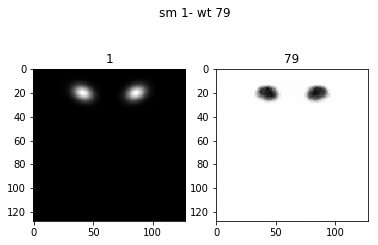

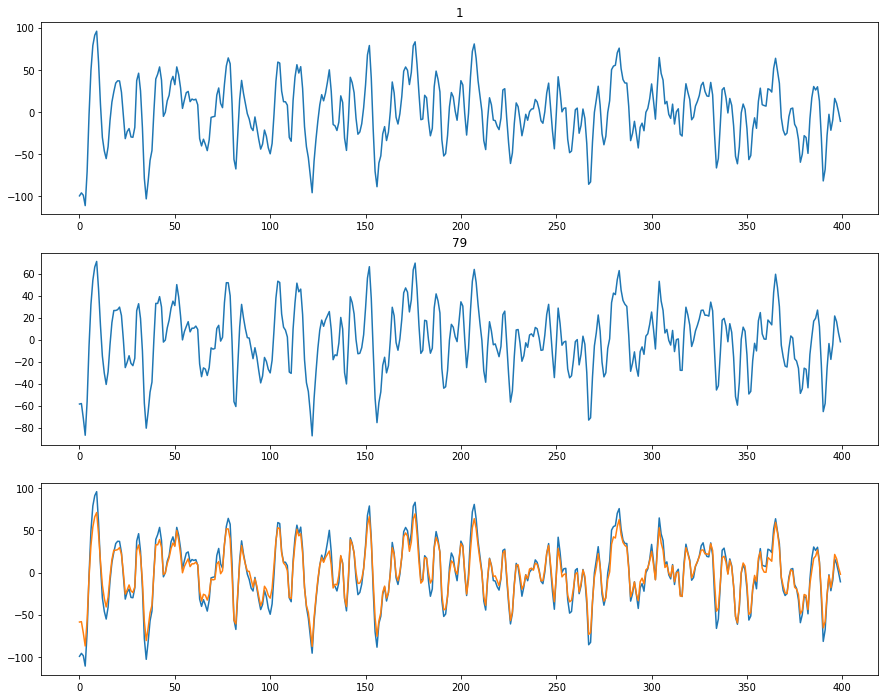

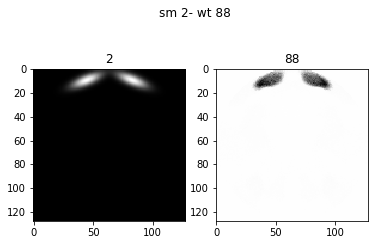

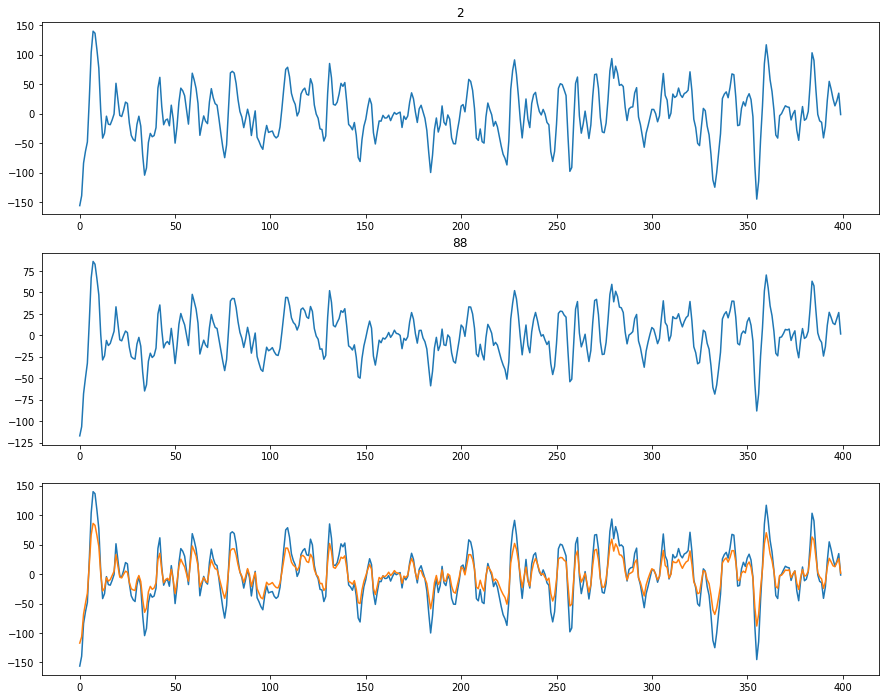

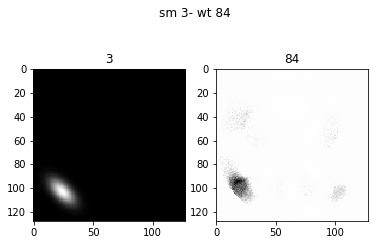

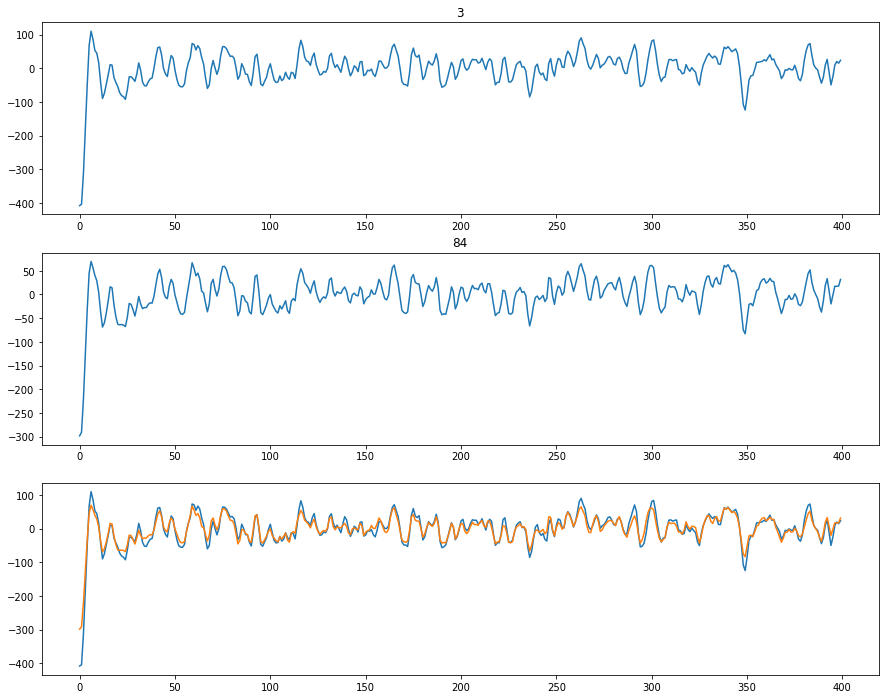

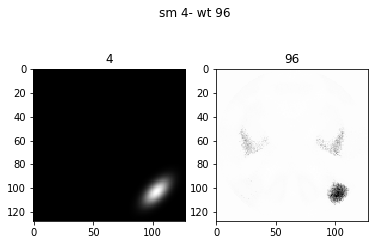

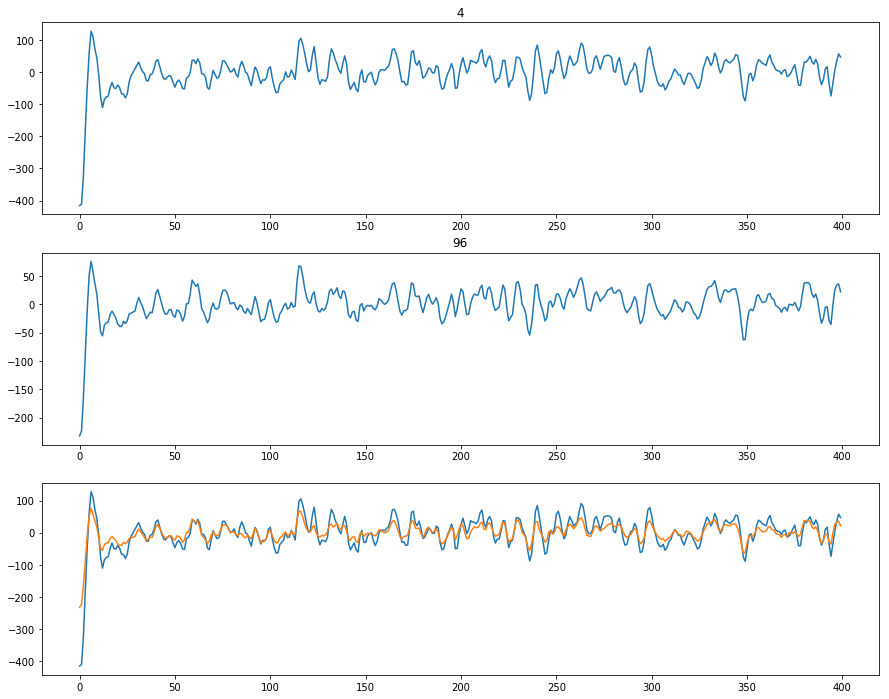

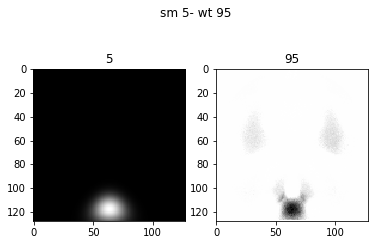

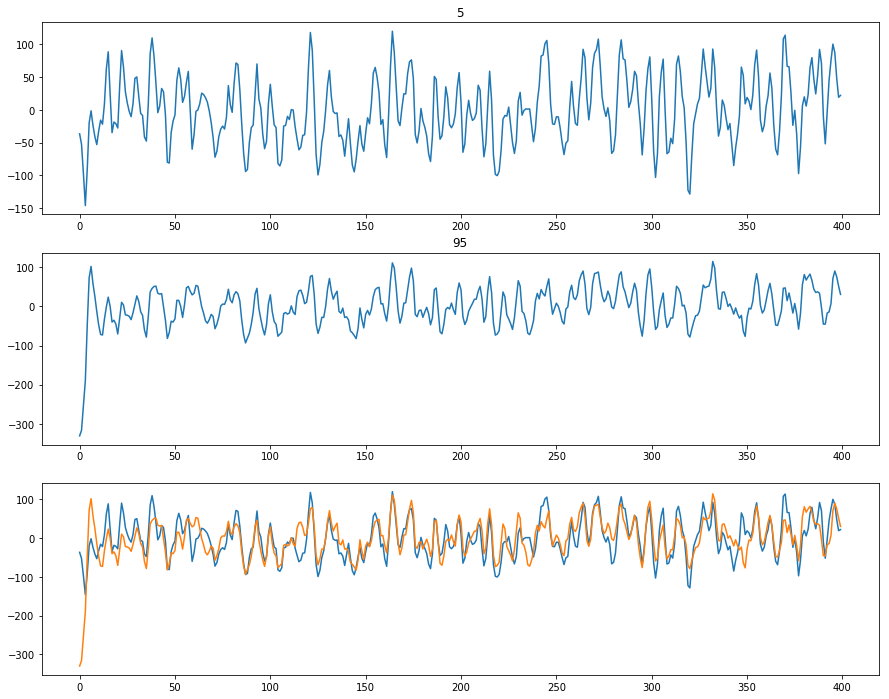

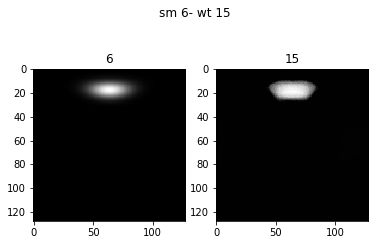

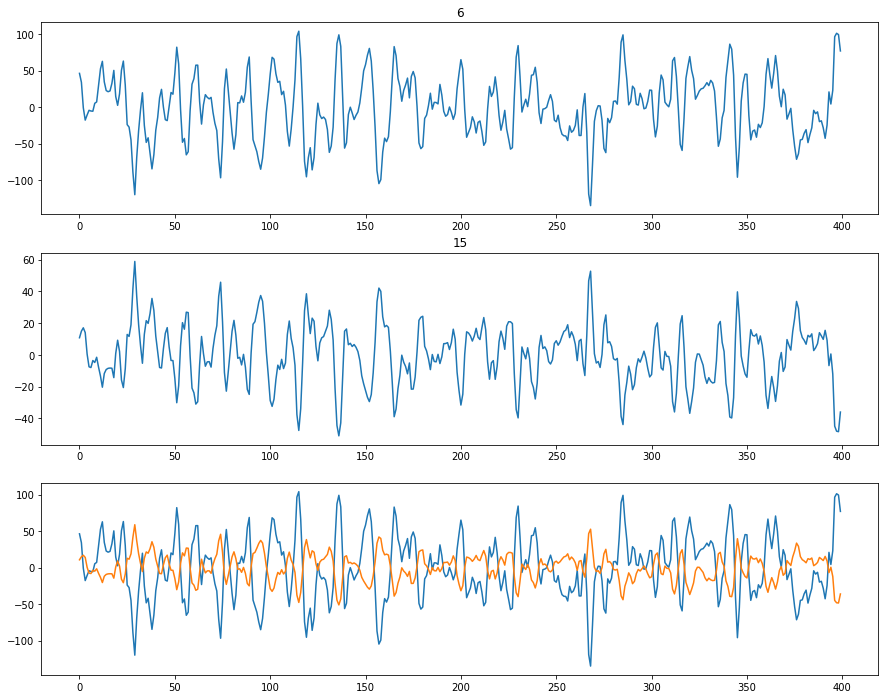

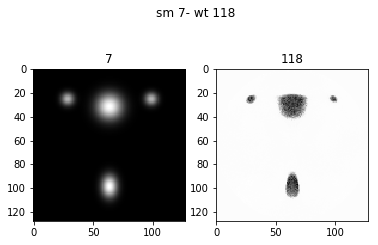

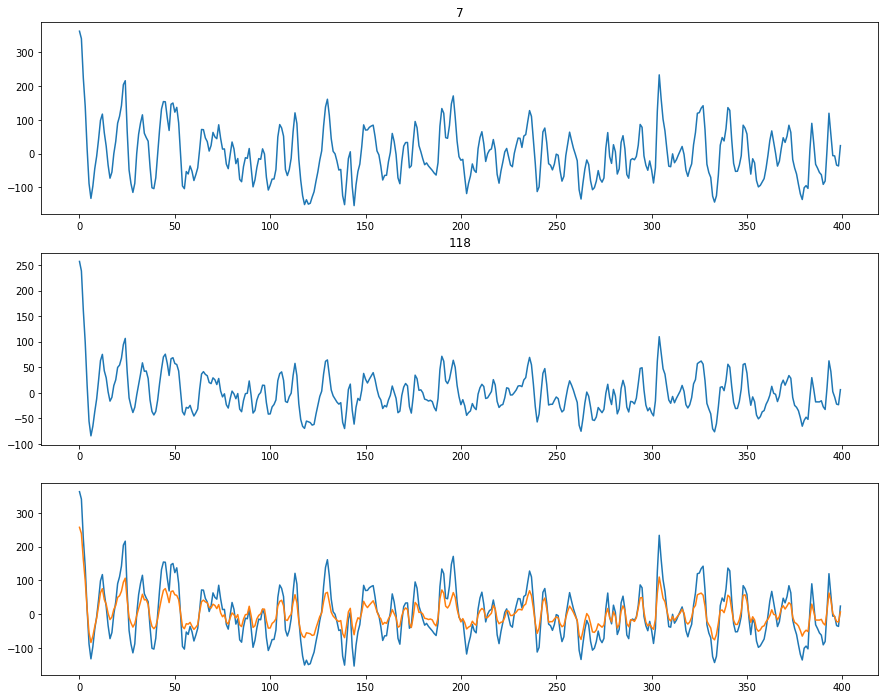

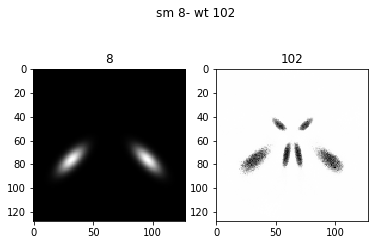

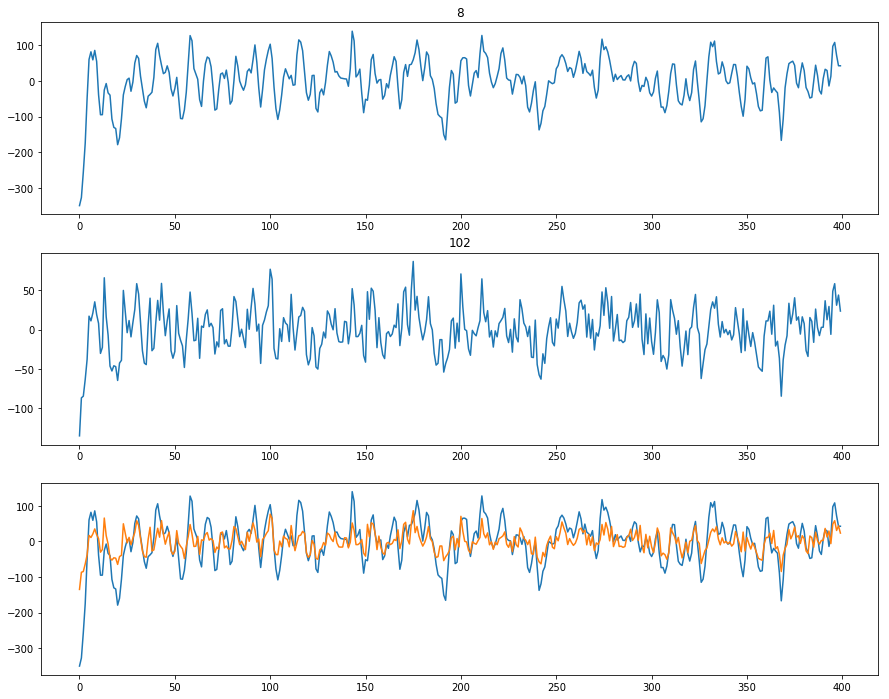

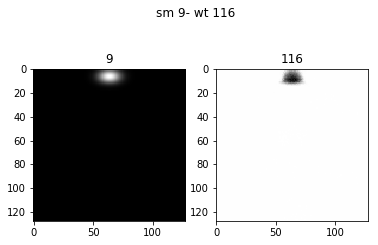

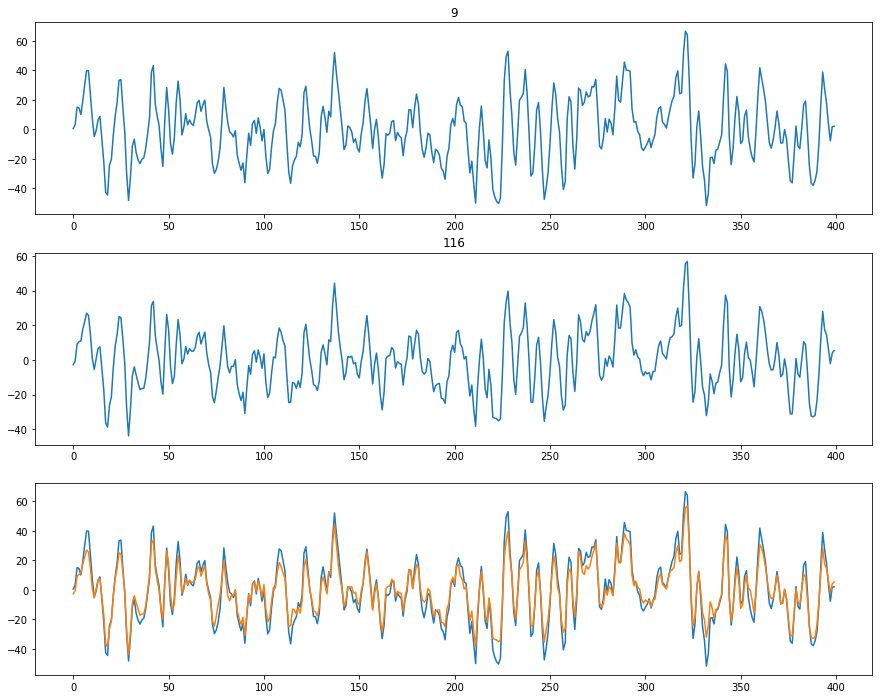

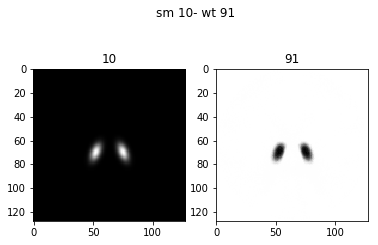

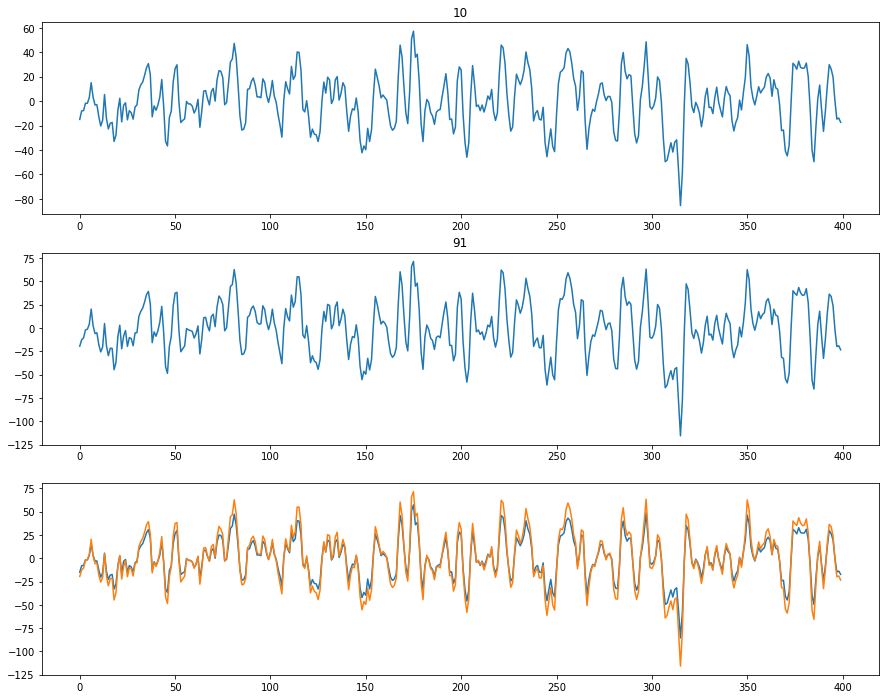

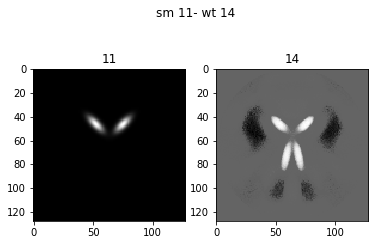

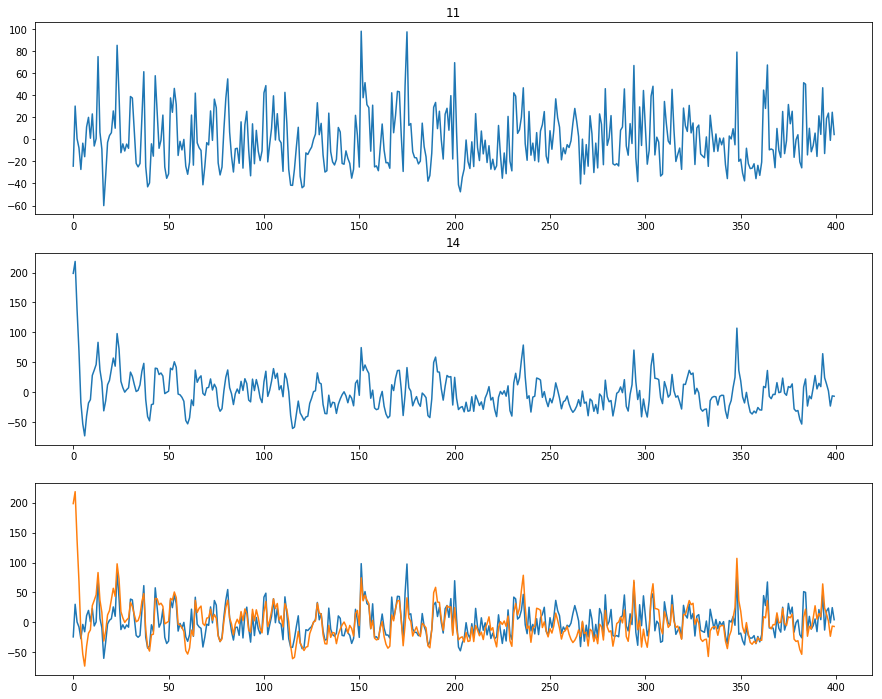

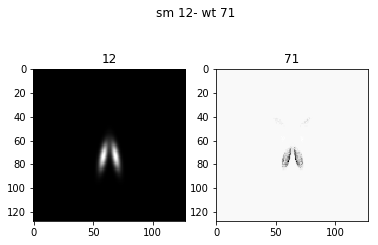

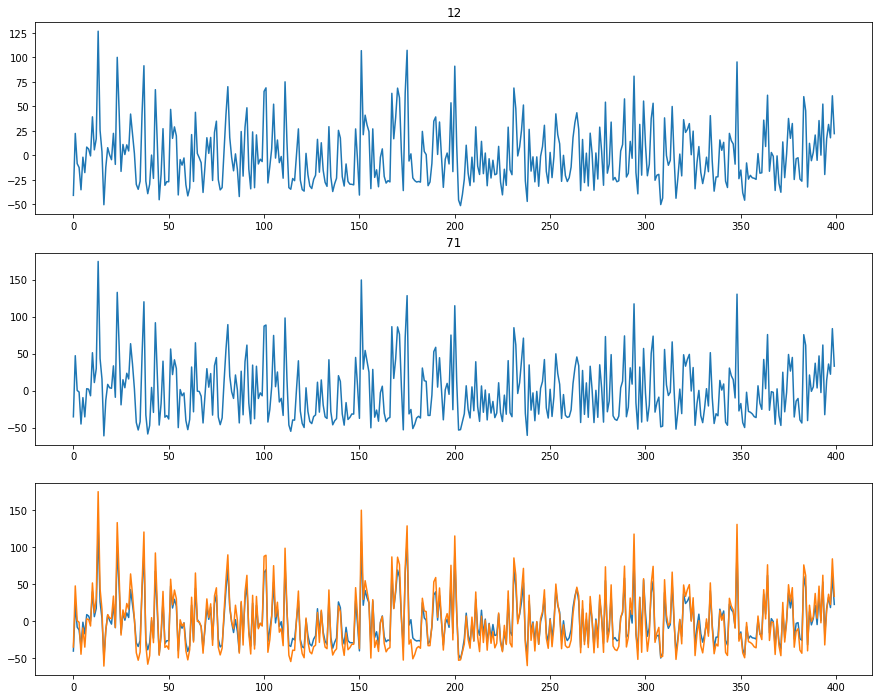

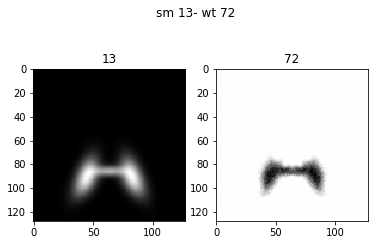

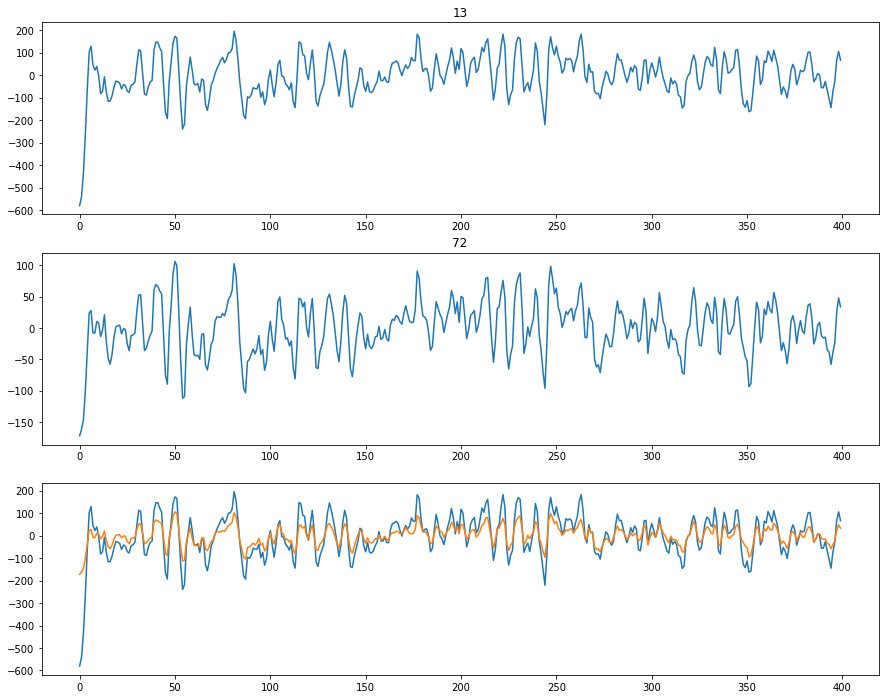

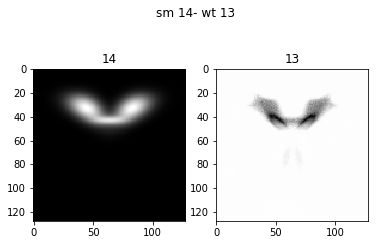

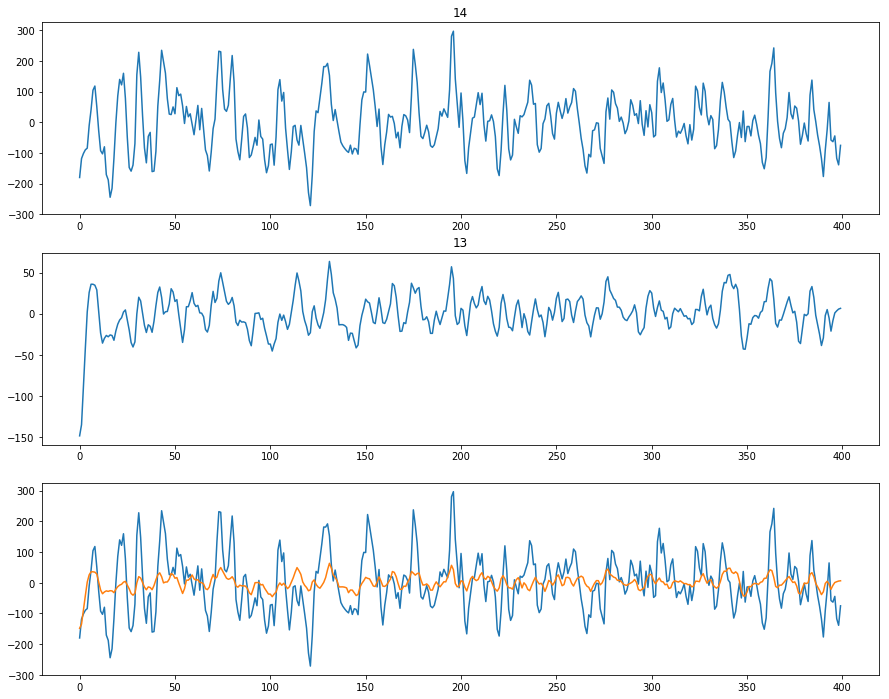

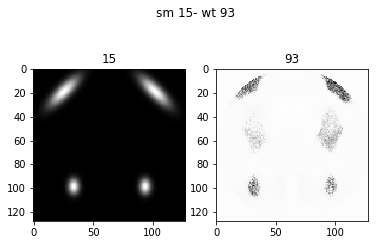

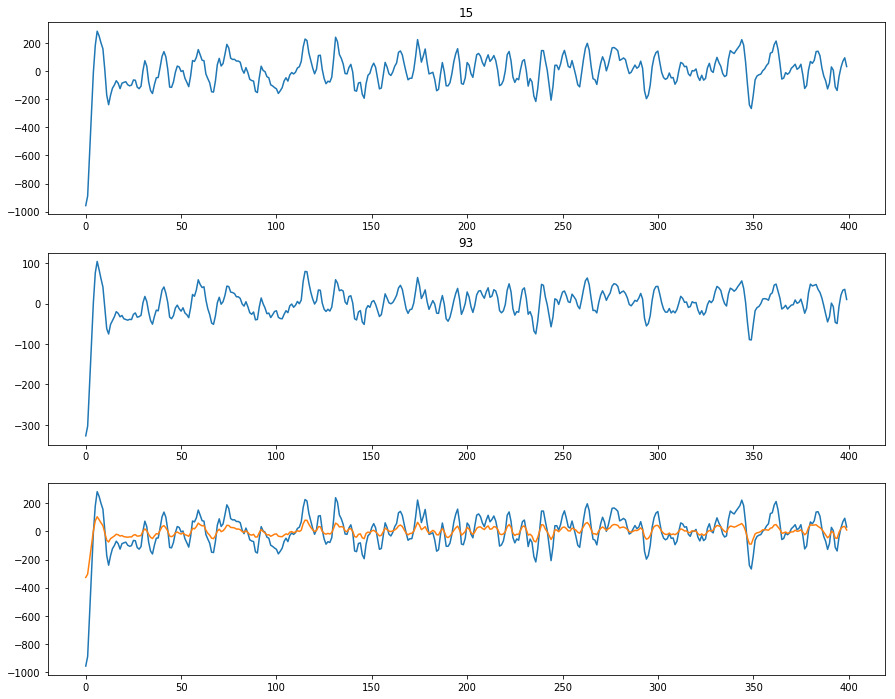

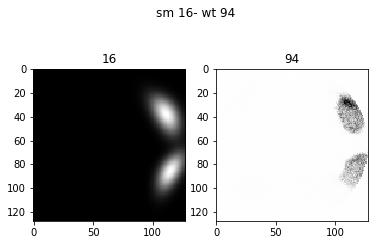

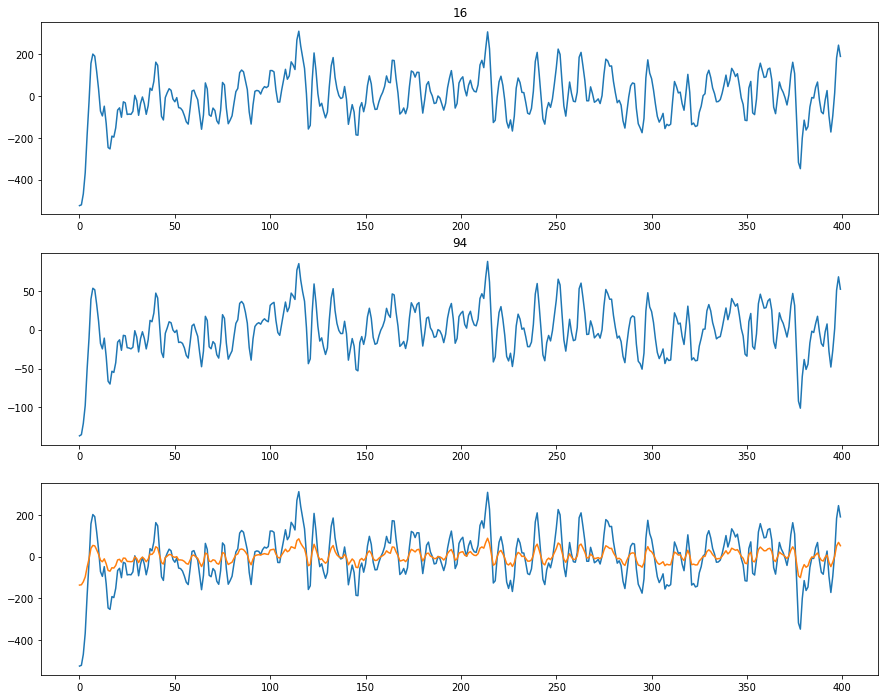

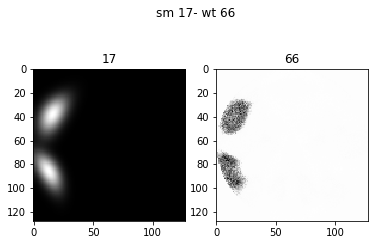

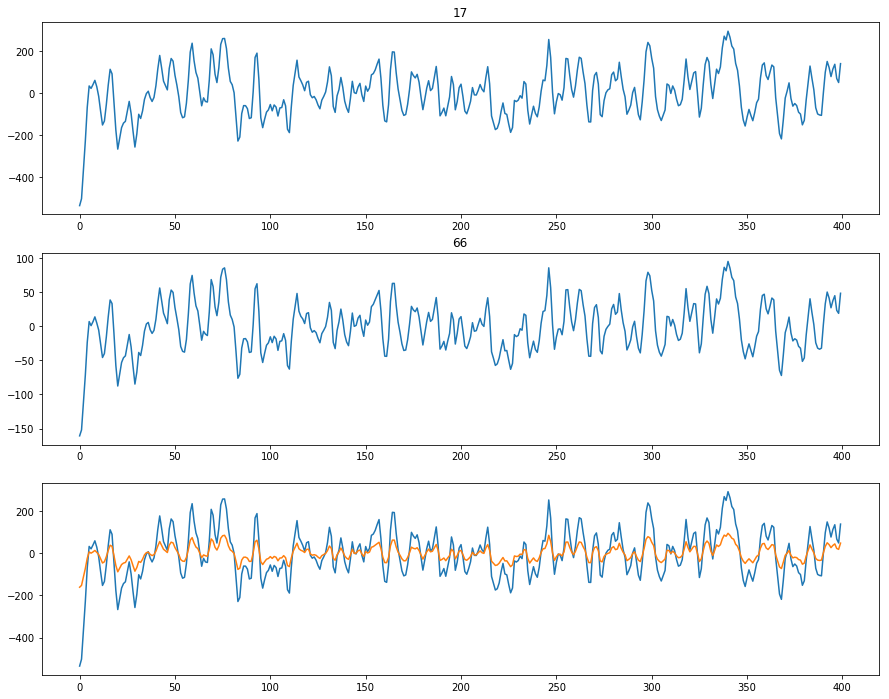

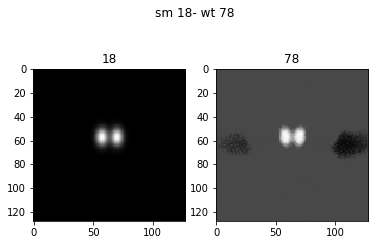

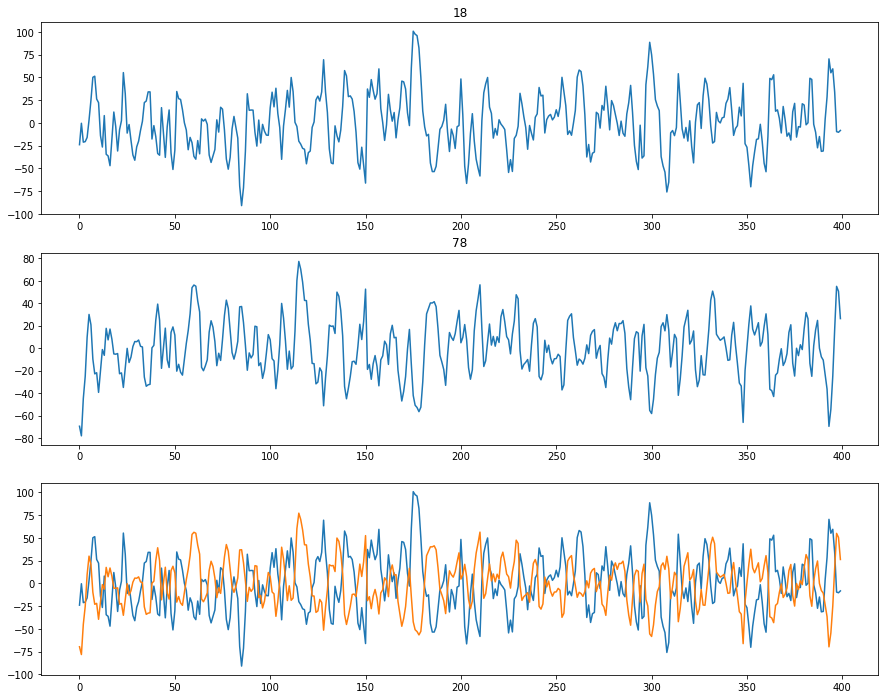

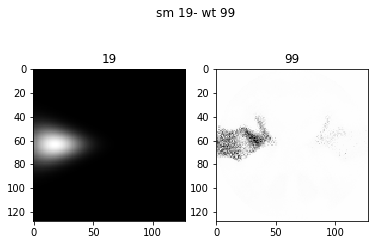

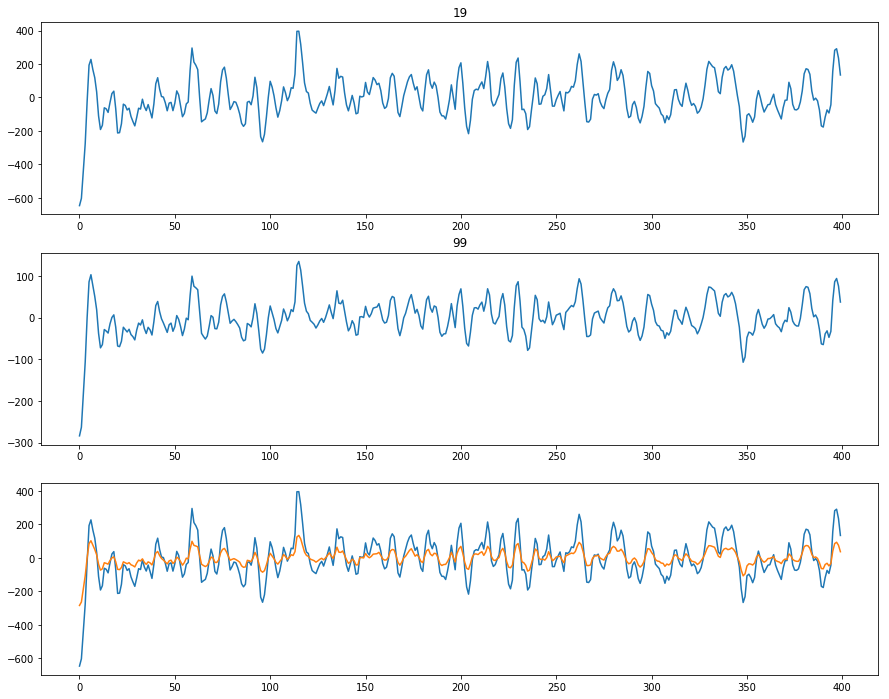

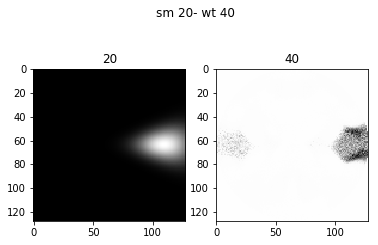

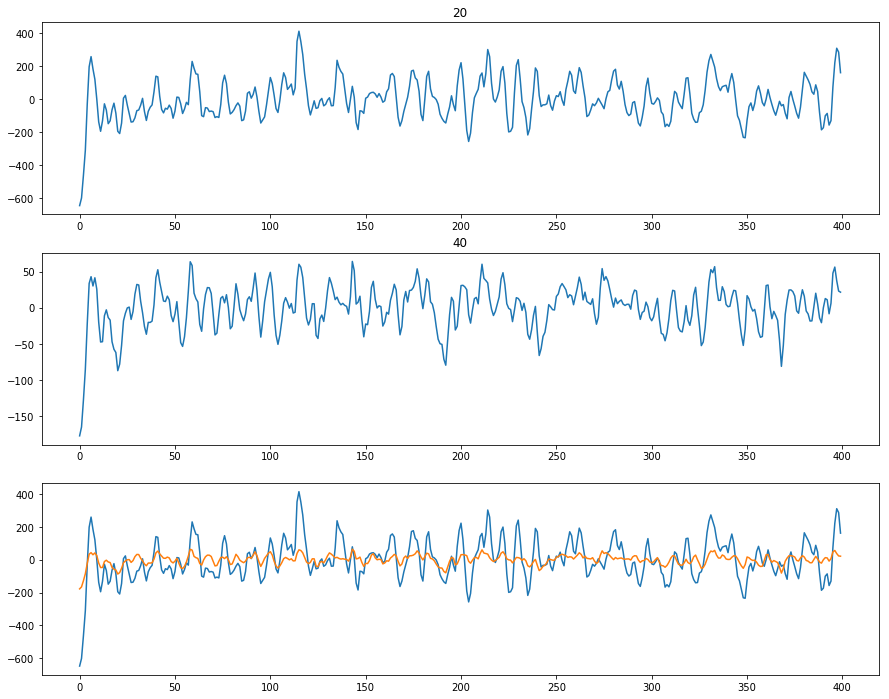

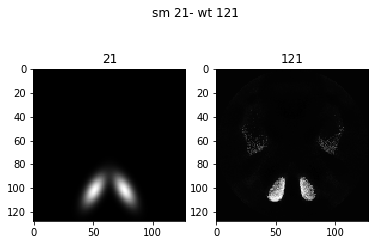

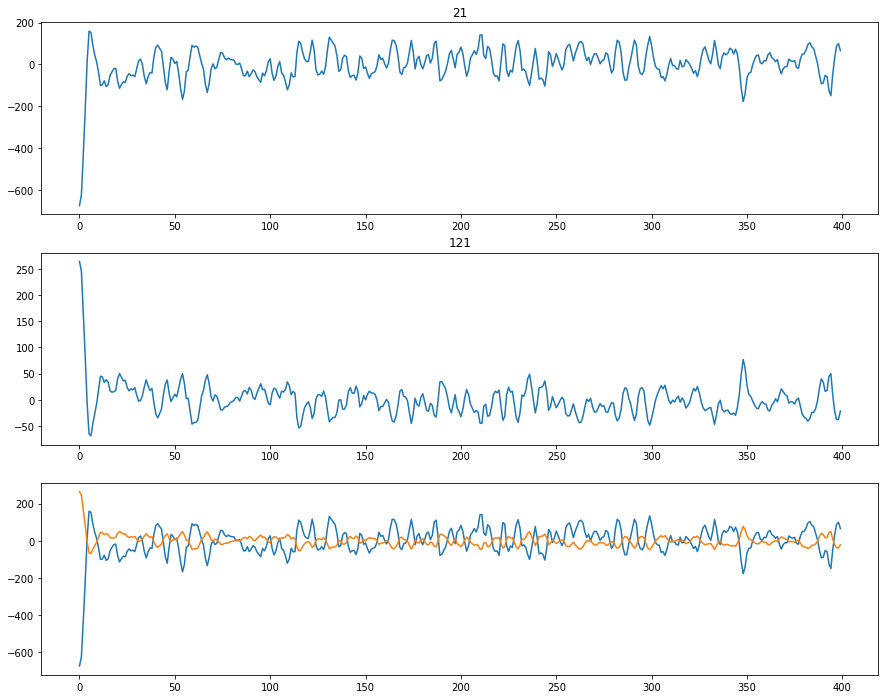

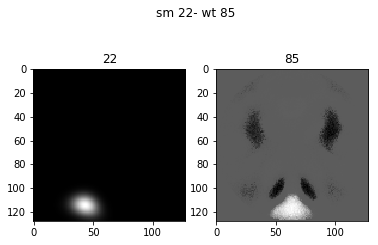

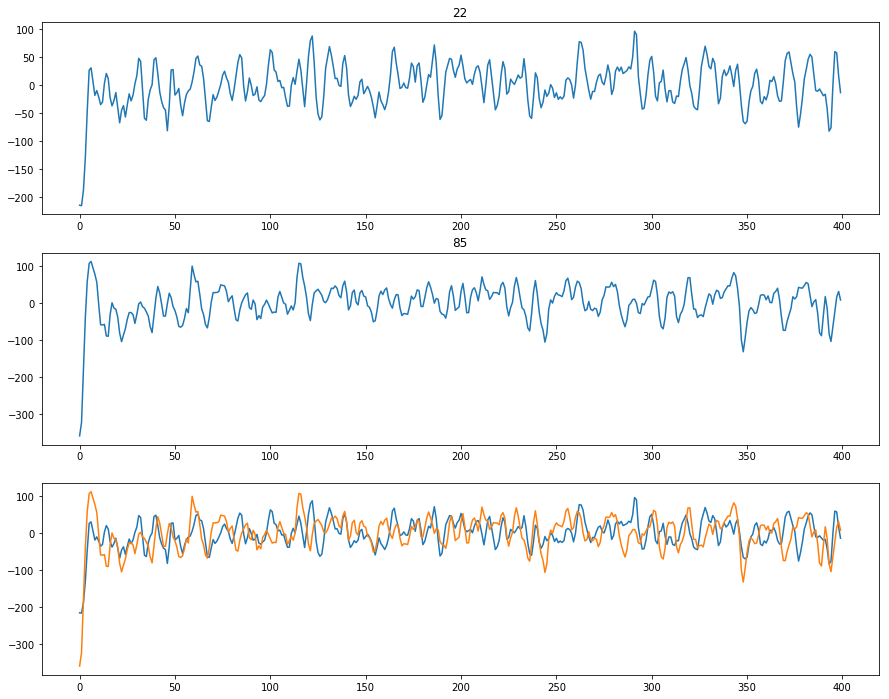

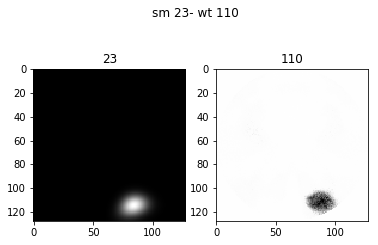

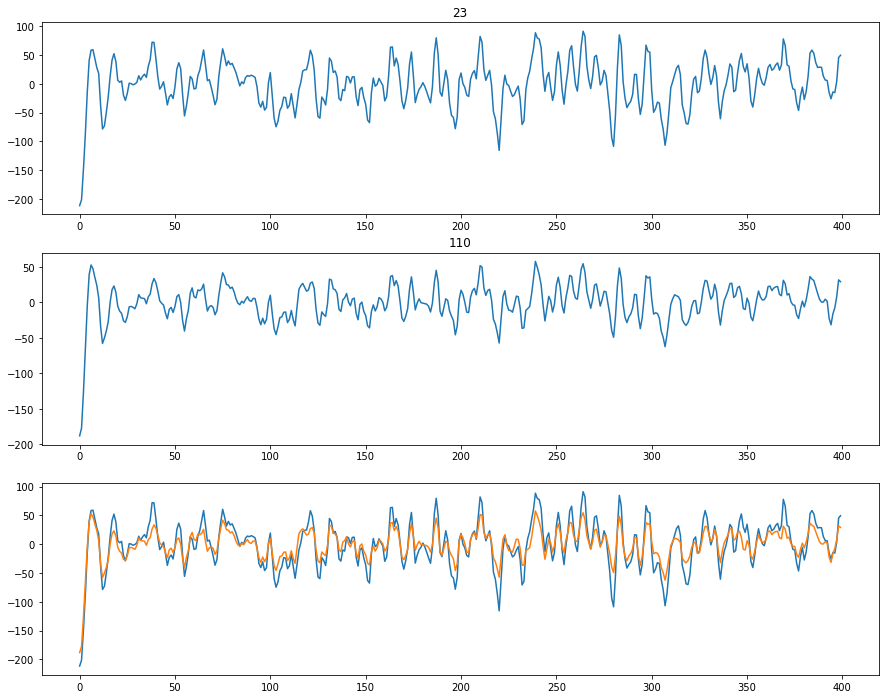

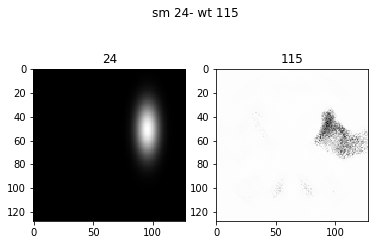

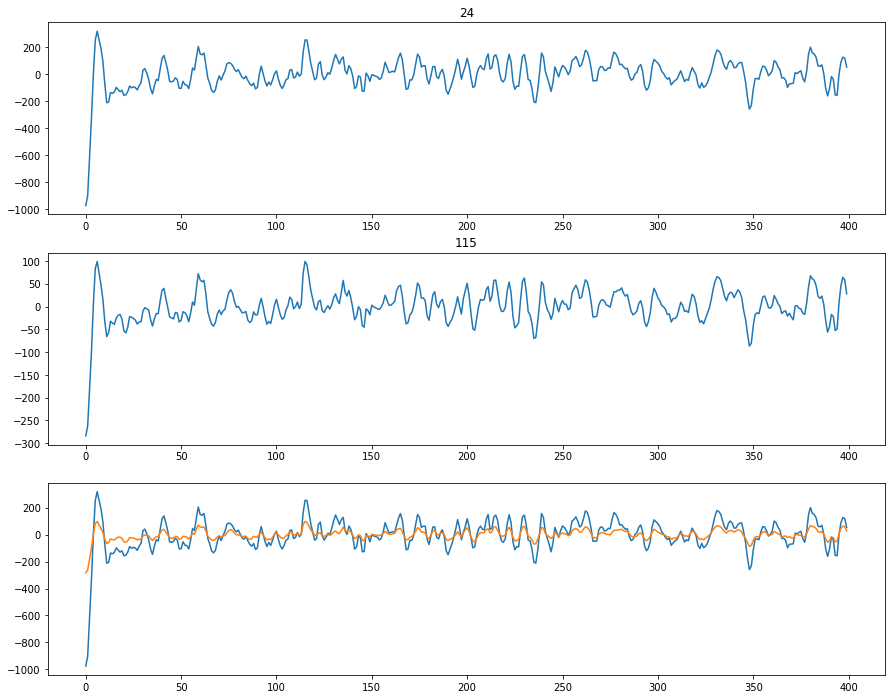

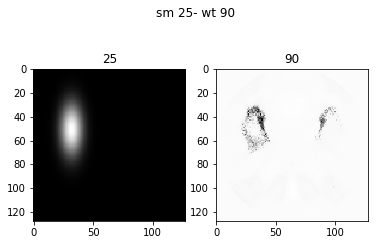

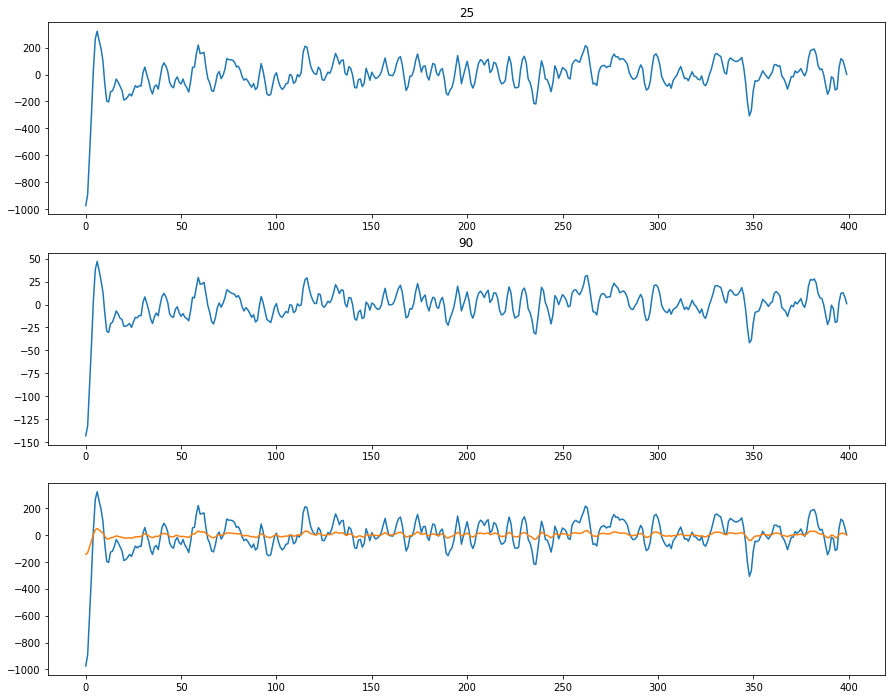

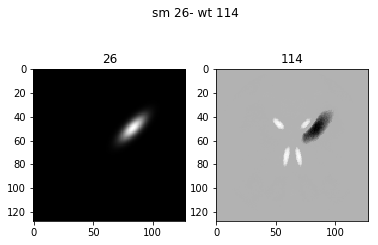

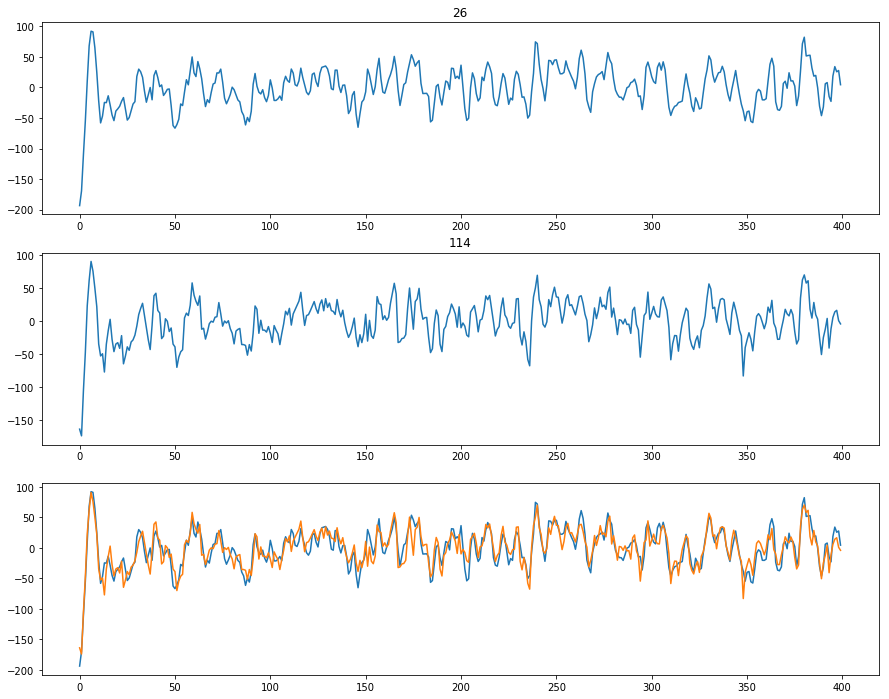

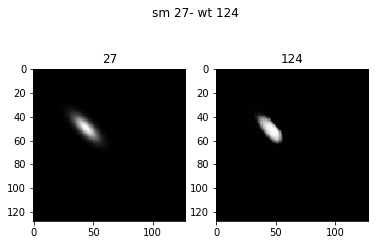

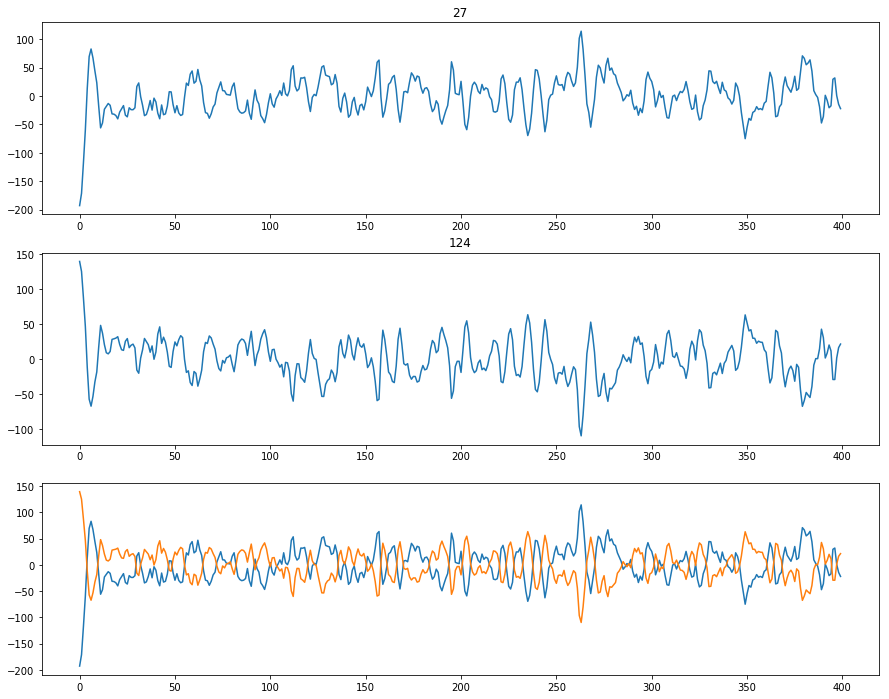

In [54]:
kv_corr={}
s_corr={}
maxcorrs=0
n=1
for matchdict in [match_pcorrs,match_ncorrs]:
    kv_dict={}
    corr_dict={}
    for k,v in matchdict.items():
        maxcorr=0
        for e in v:
            scorr = abs(pearsonr(np.ravel(wts_stdz['neuron_{}'.format(e)]),np.ravel(sm_cmpnts[k]))[0])
            if scorr>maxcorr:
                maxcorr=scorr
                kv_dict[k]=e
                corr_dict[k]=scorr
    if n==1: 
        kv_corr = kv_dict
        s_corr = corr_dict
    else: 
        for ke,va in corr_dict.items():
            if corr_dict[ke]>s_corr[ke]:
                kv_corr[ke]=kv_dict[ke]
    n+=1

for kk,vv in kv_corr.items():                 
    f = plt.figure()
    f.suptitle('sm {}- wt {}'.format(kk,vv))
    ax = plt.subplot(121)
    ax.set_title(kk)
    plt.imshow(sm_cmpnts[kk], cmap='gray')
    ax1 = plt.subplot(122)
    ax1.set_title(vv)
    plt.imshow(wts_stdz['neuron_{}'.format(vv)], cmap='gray')

    f1 = plt.figure(figsize=(15,12))
    ax = plt.subplot(311)
    ax.set_title(kk)
    plt.plot(avg_gt[int(kk)-1])
    ax2 = plt.subplot(312)
    ax2.set_title(vv)
    plt.plot(avg_wt[int(vv)-1])
    ax3 = plt.subplot(313)
    plt.plot(avg_gt[int(kk)-1])
    plt.plot(avg_wt[int(vv)-1])

## 26 of 27 (96.3%) correct matches are made 

### Matching Criteria: 
+ First, temporal correlation is used to match each single-subject activation map time course to a ground truth component time course
+ Next, if the subjects for a single activation map match with different ground truth components, the ground truth component whose spatial correlation is highest with that activation map is taken as the single best match

### Functional connectivity analysis: 
#### Plot all spatial correlations to ground truth for any weight matrix that has at least one correlation >= the threshold

### Calculate the spatial correlations above a given threshold

In [12]:
scorrs, _ = spat_corr(wts_stdz, gt_cmpnts, max_only=False)

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


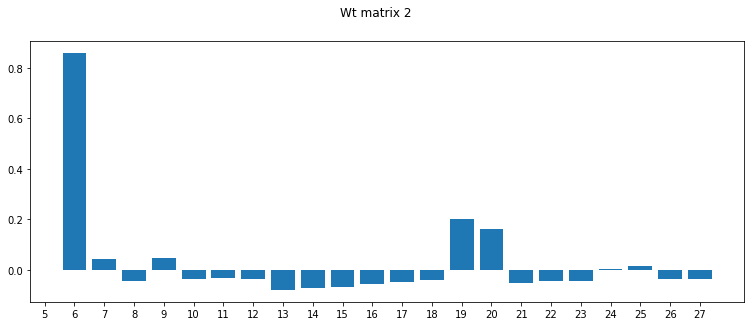

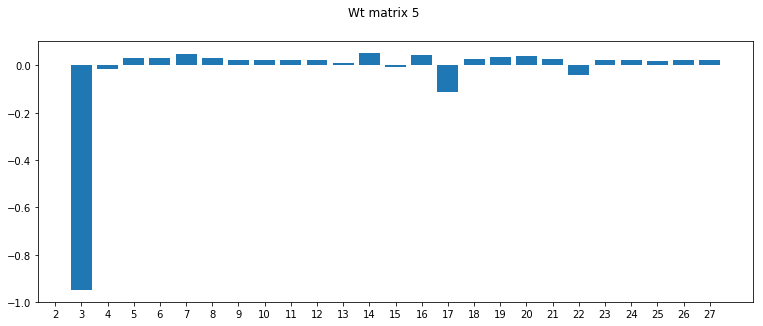

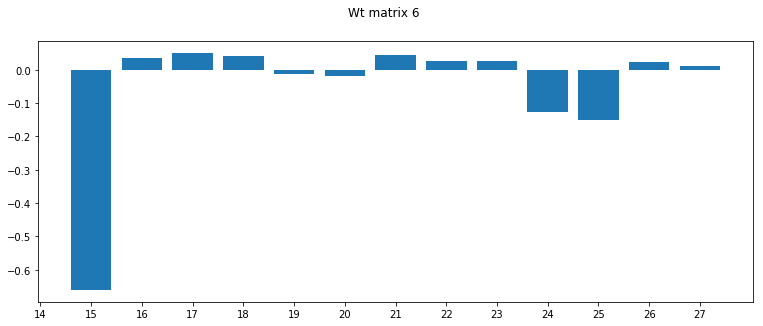

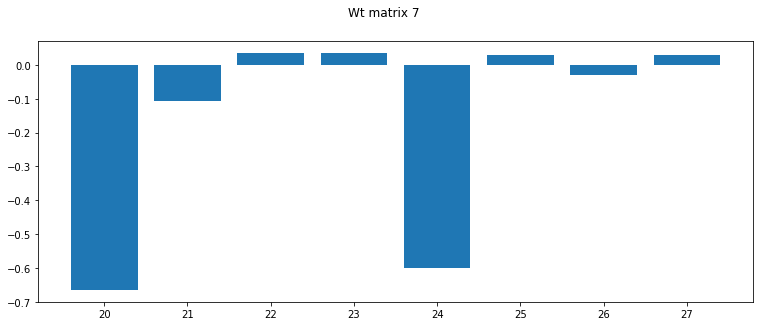

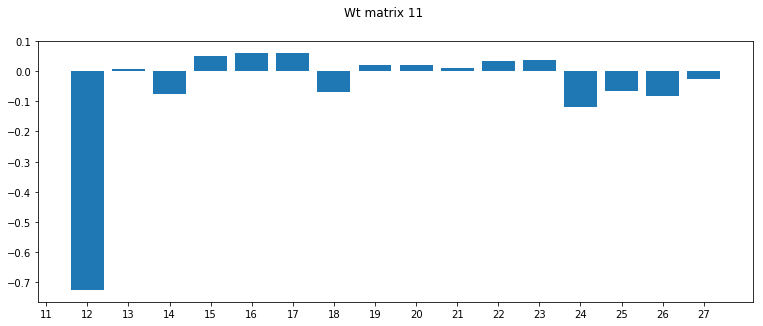

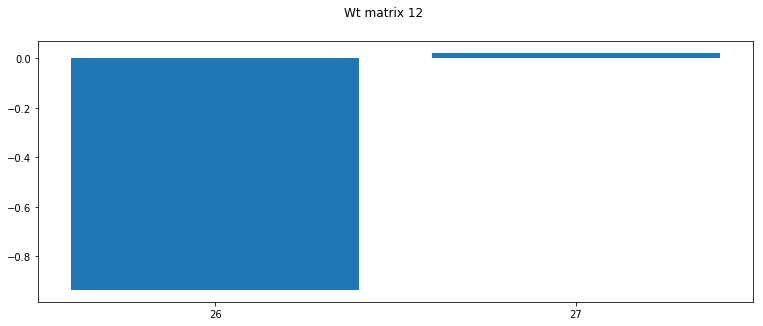

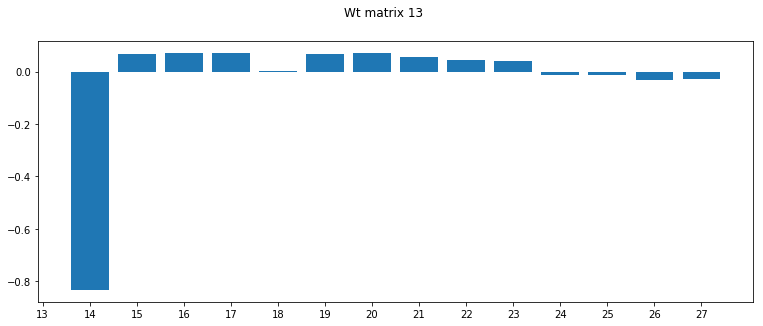

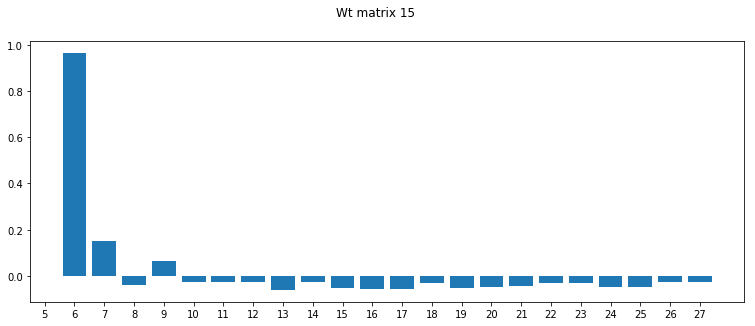

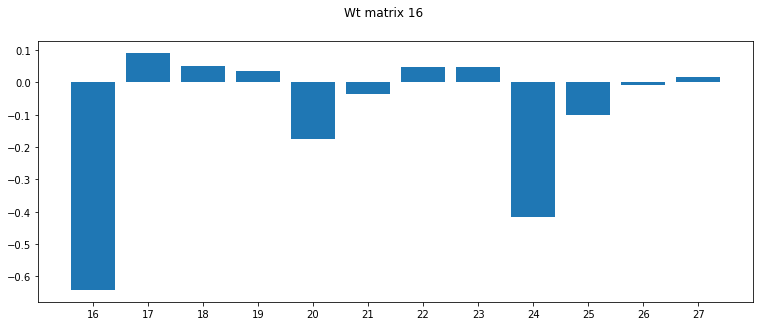

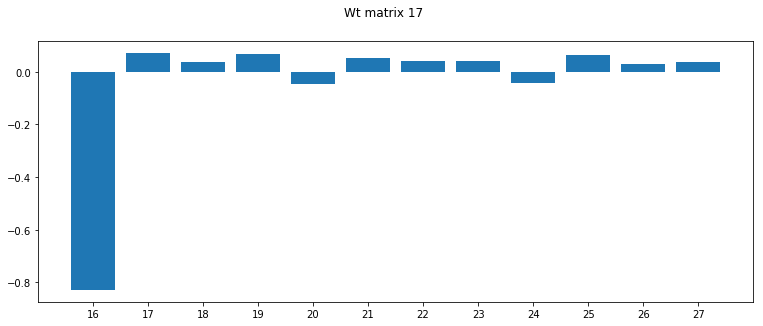

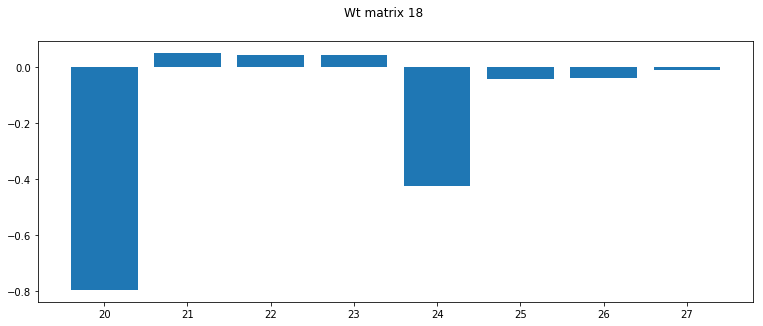

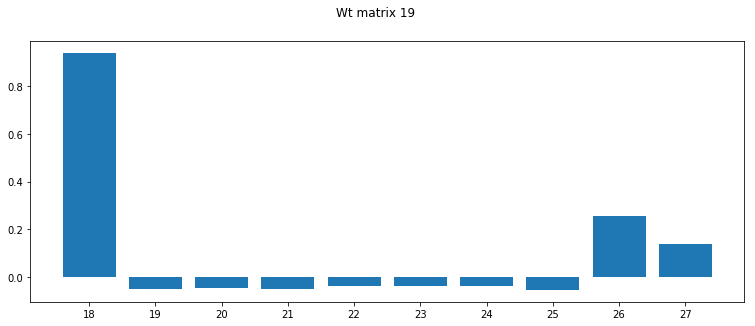

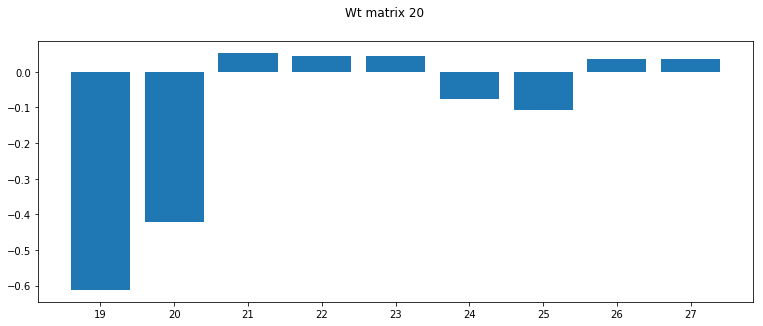

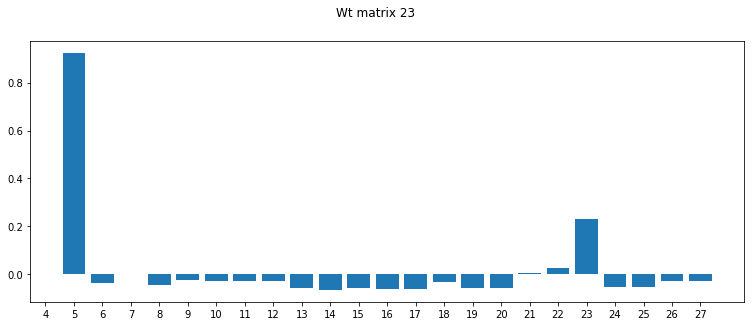

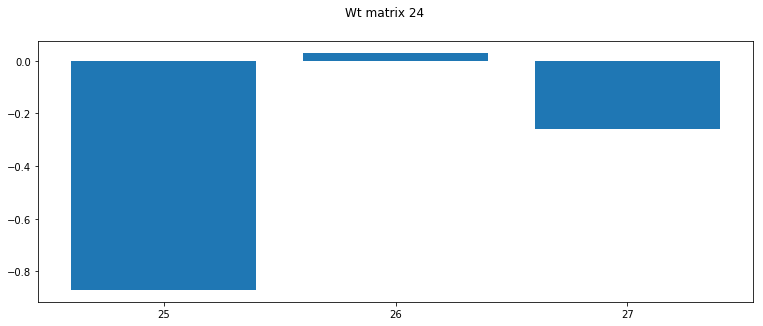

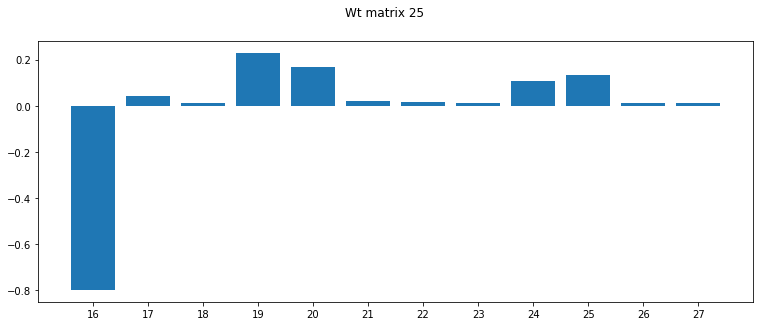

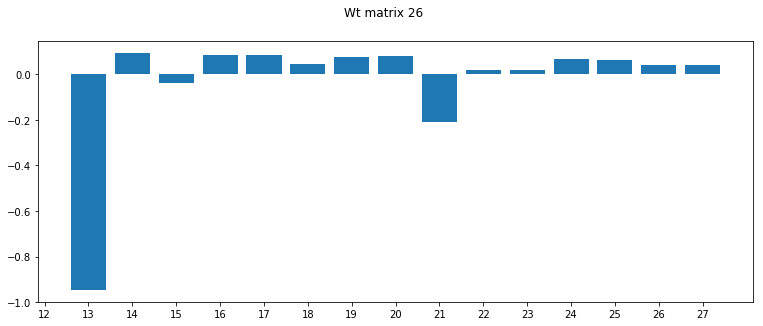

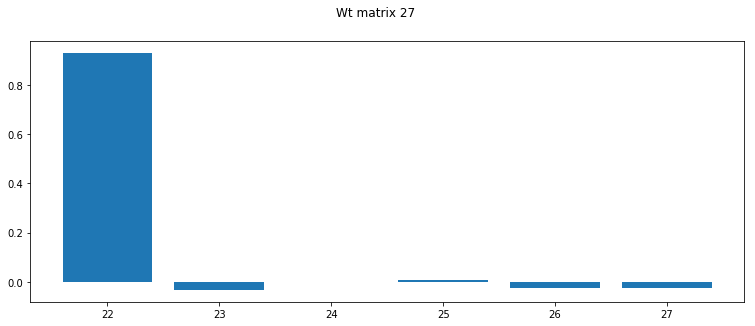

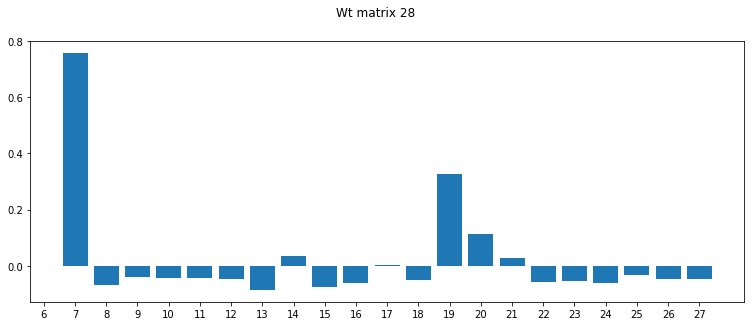

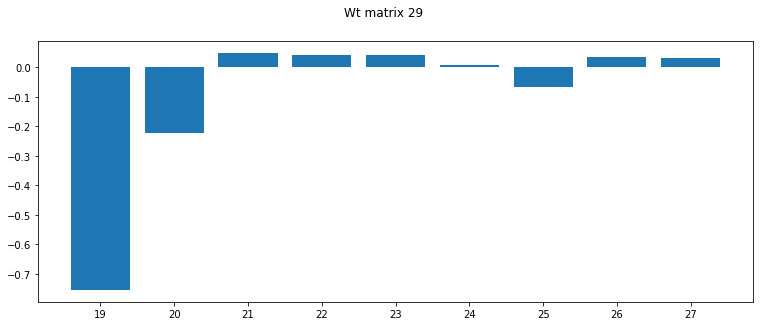

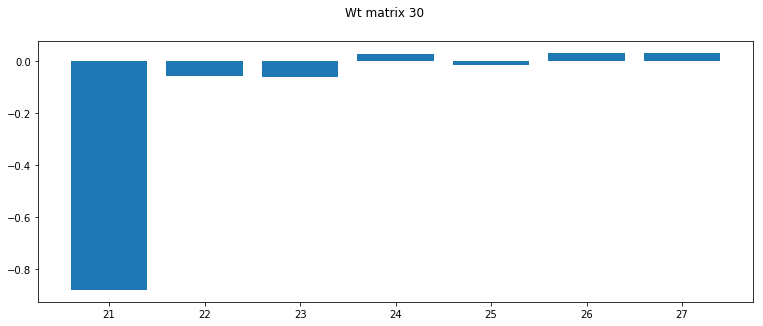

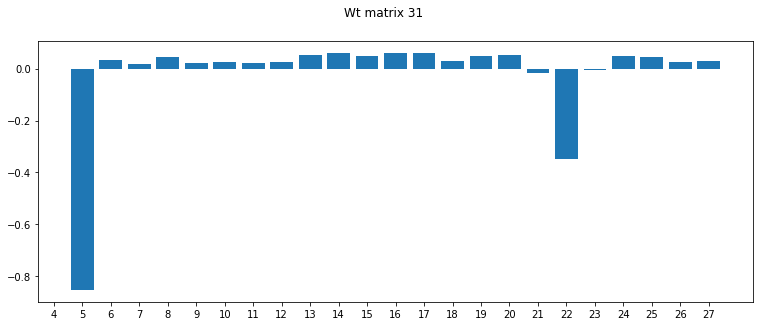

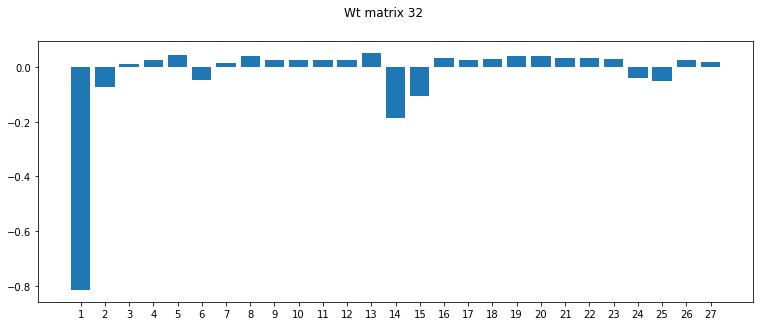

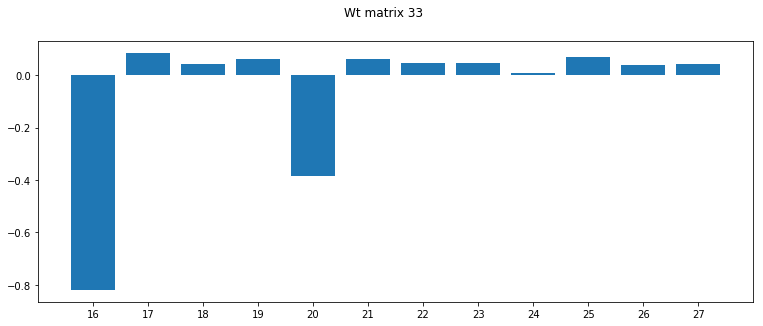

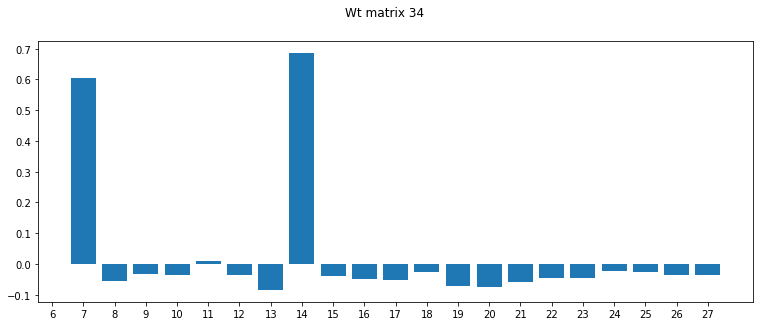

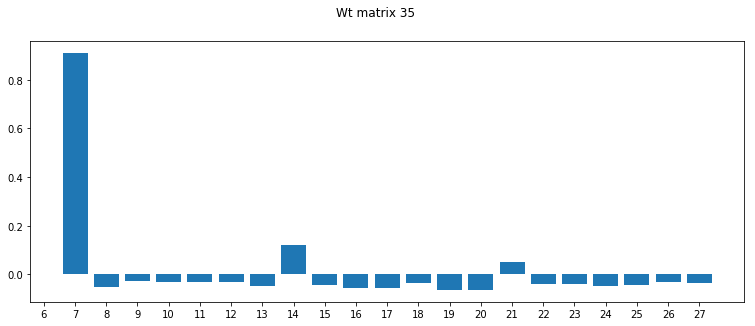

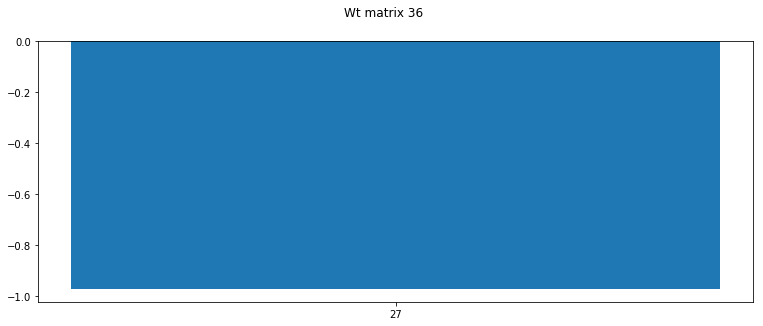

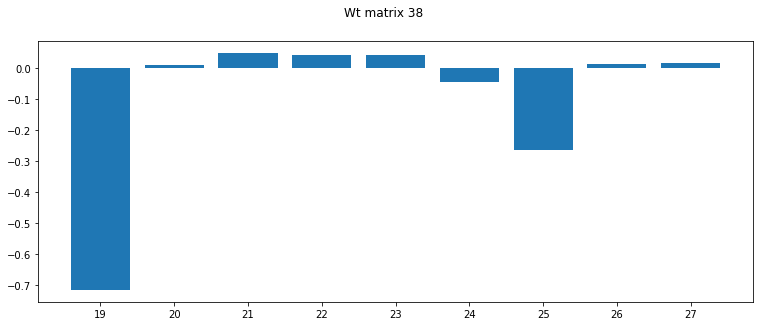

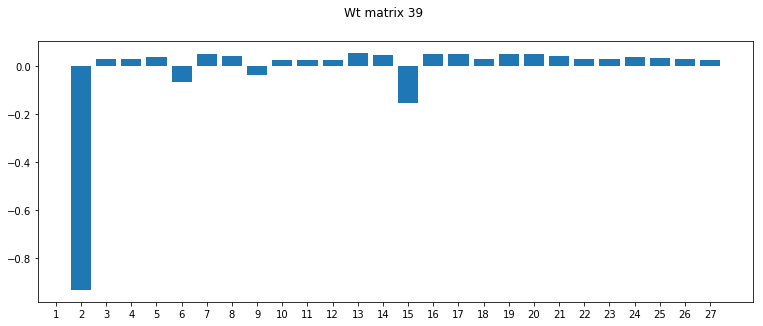

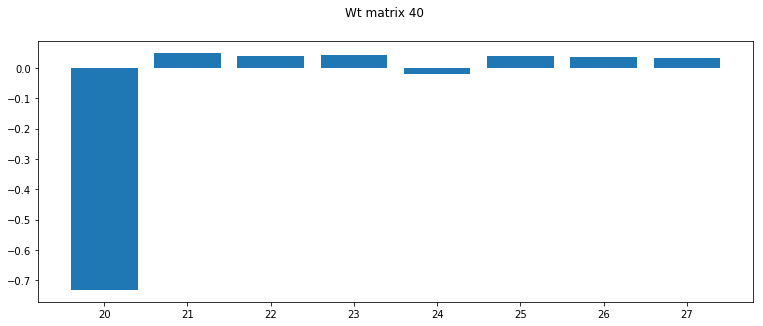

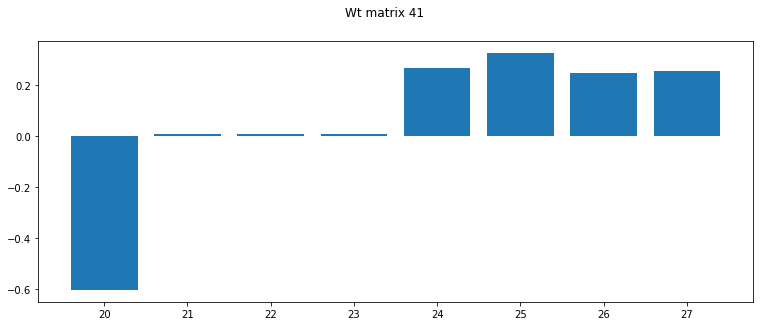

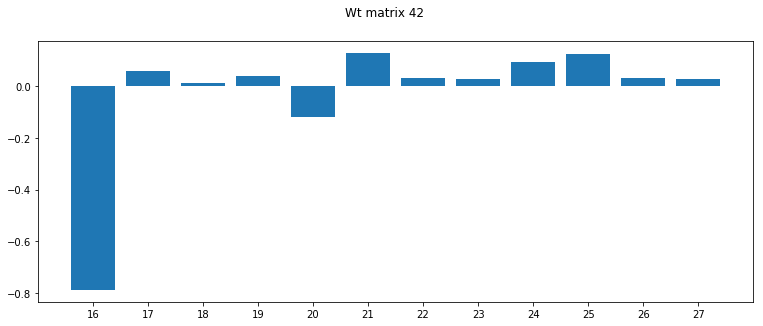

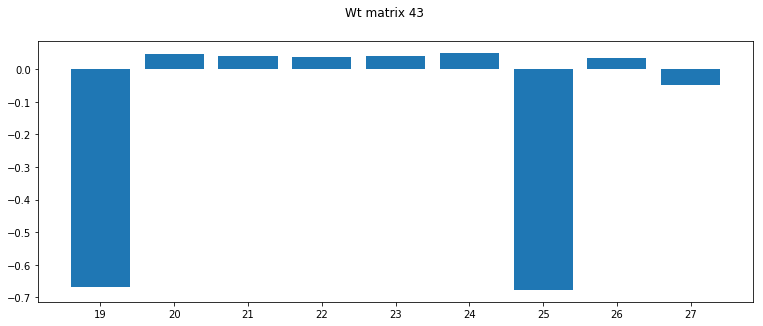

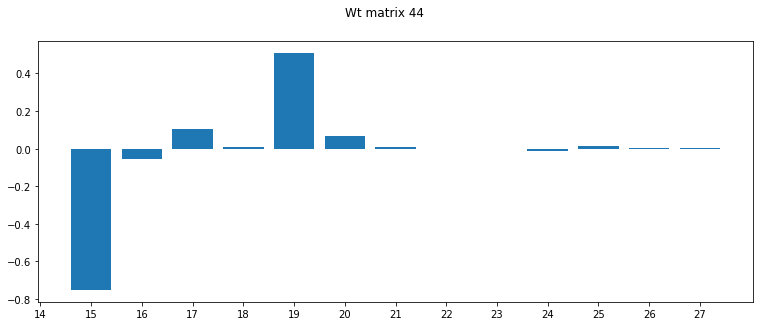

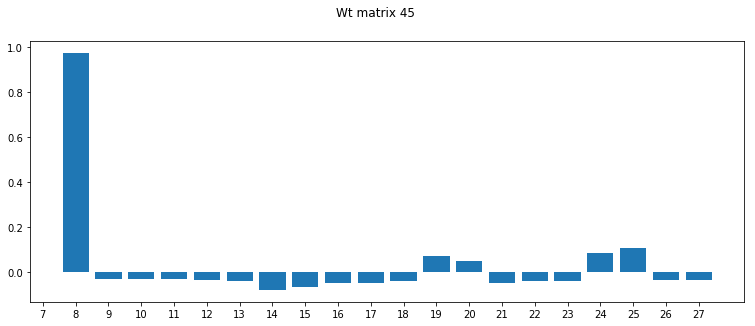

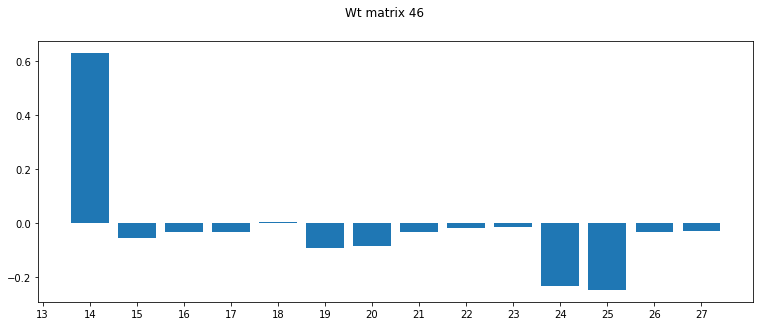

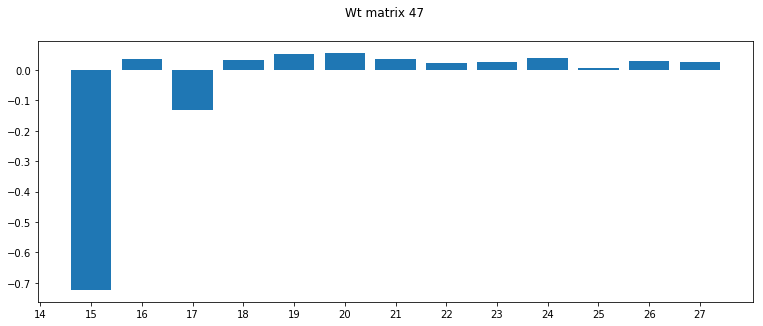

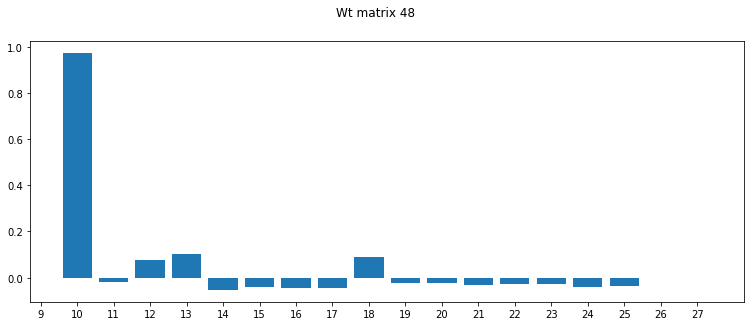

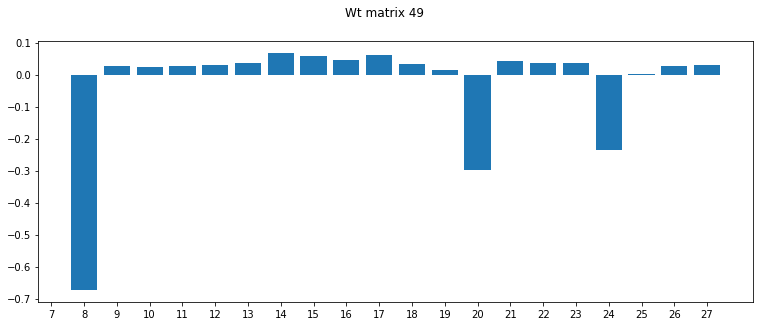

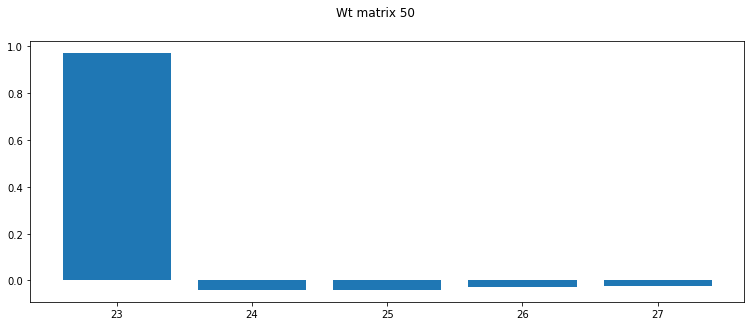

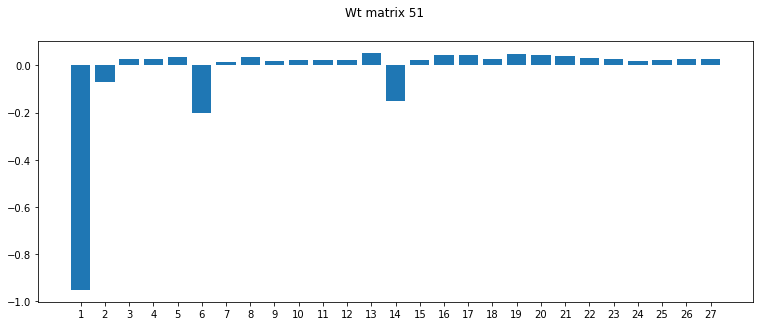

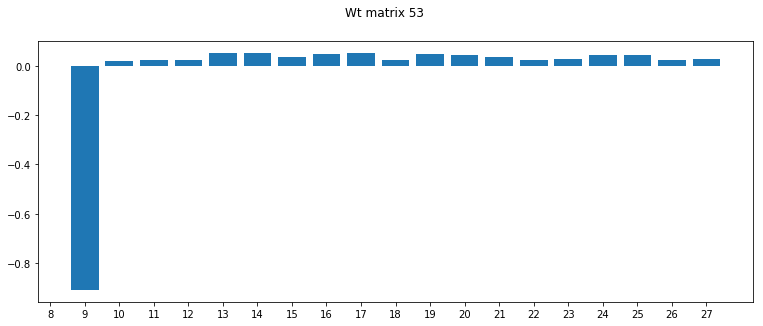

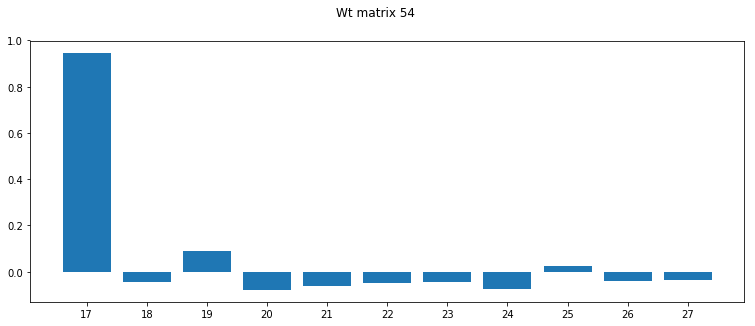

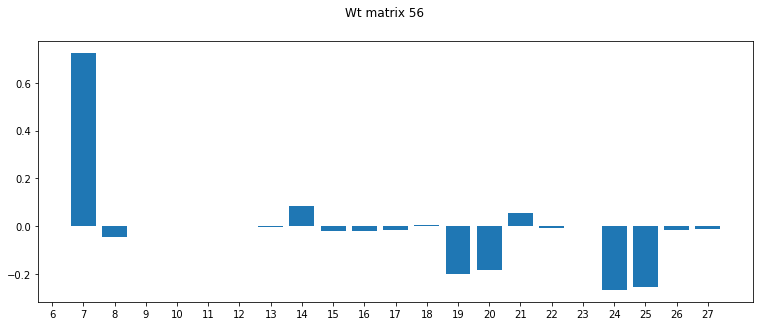

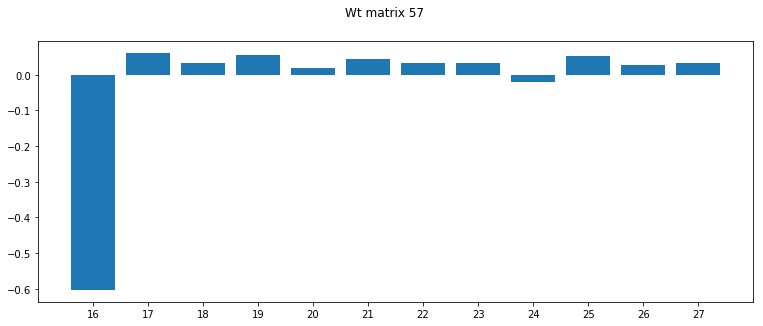

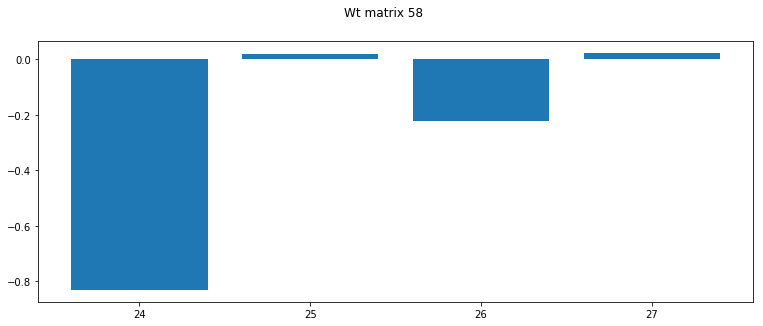

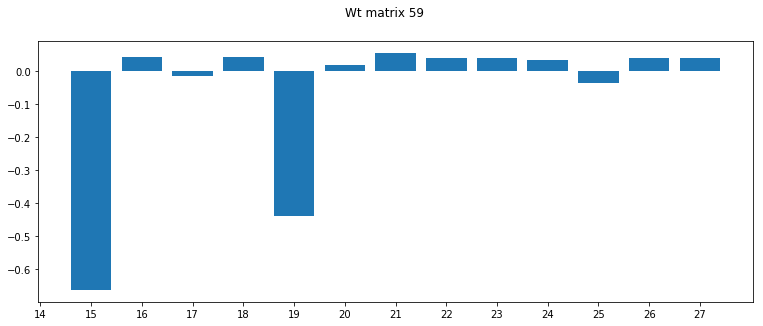

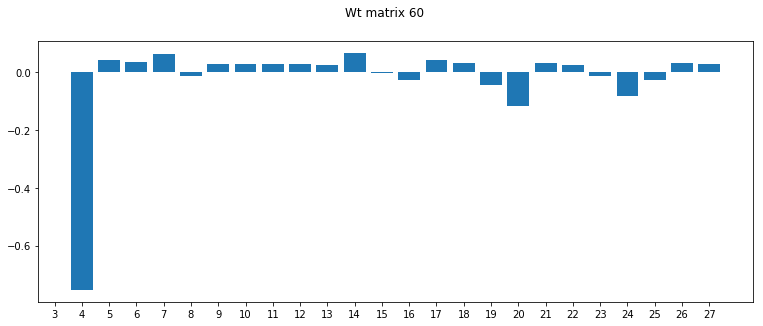

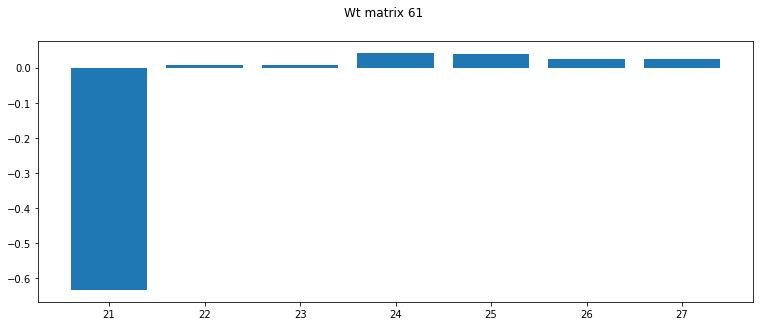

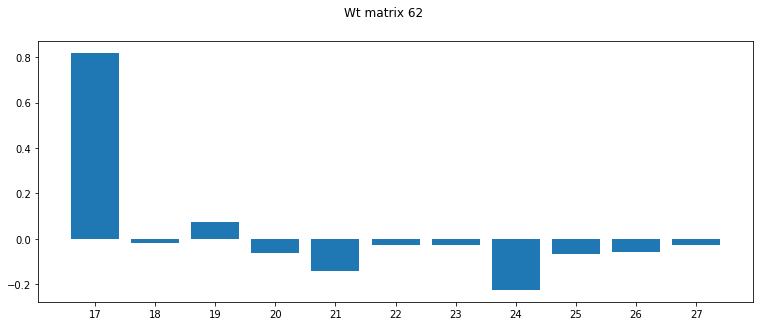

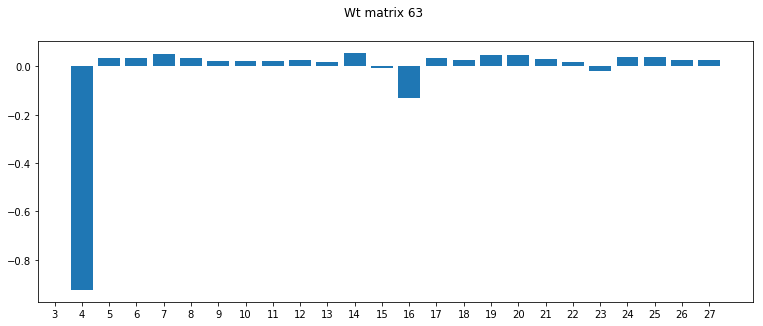

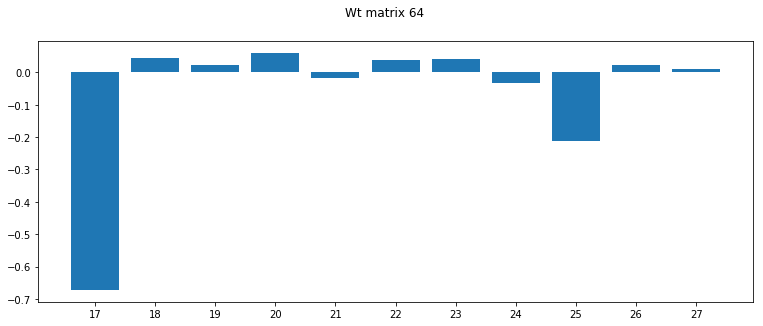

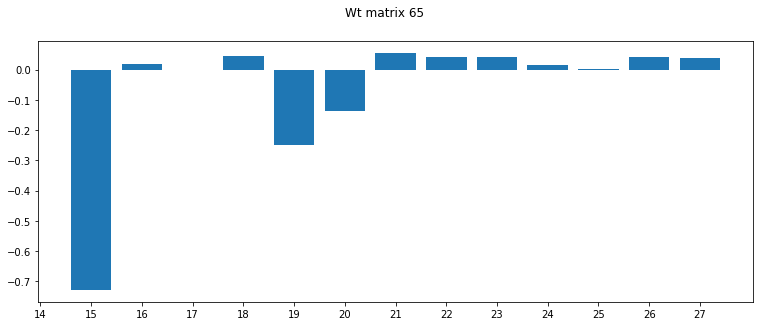

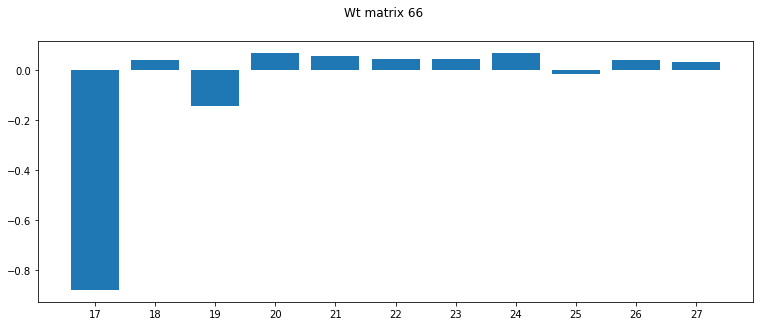

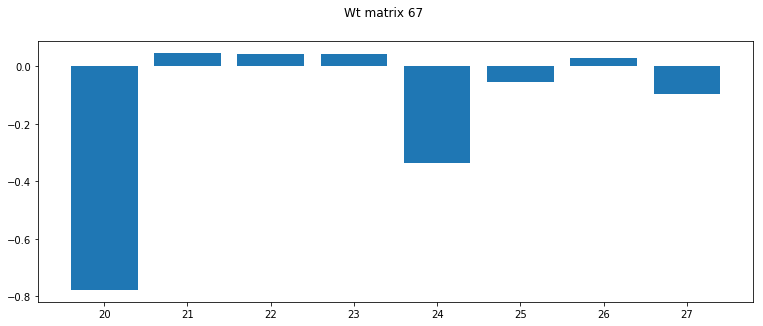

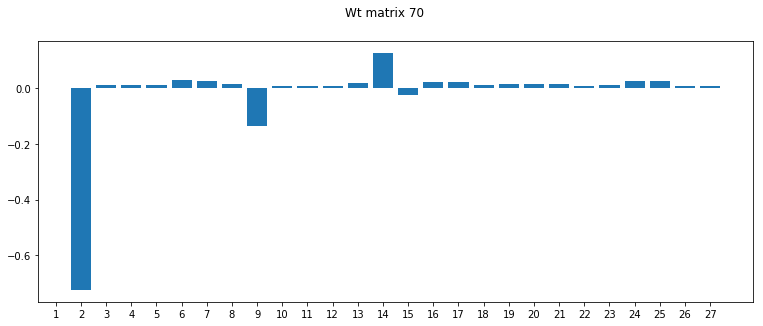

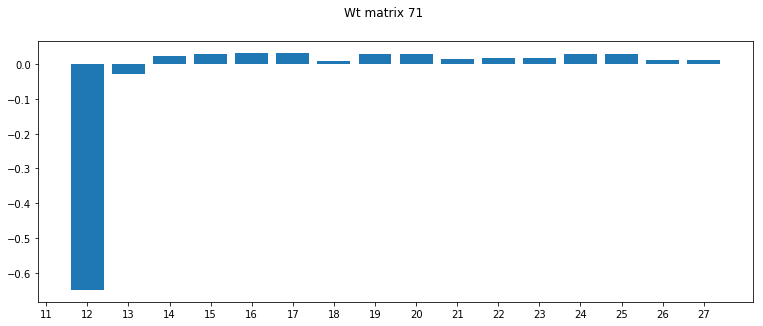

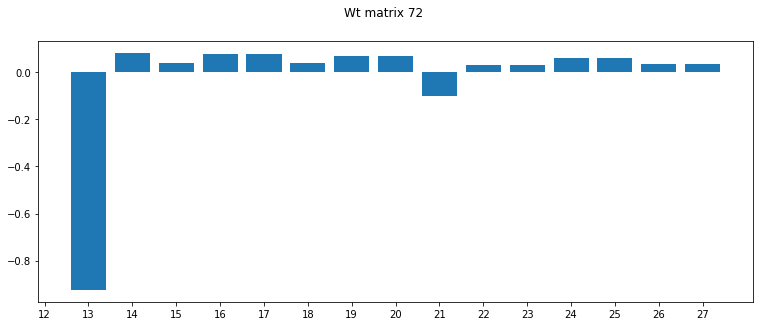

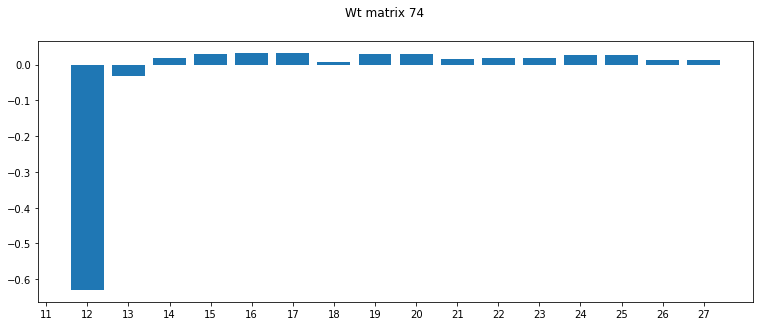

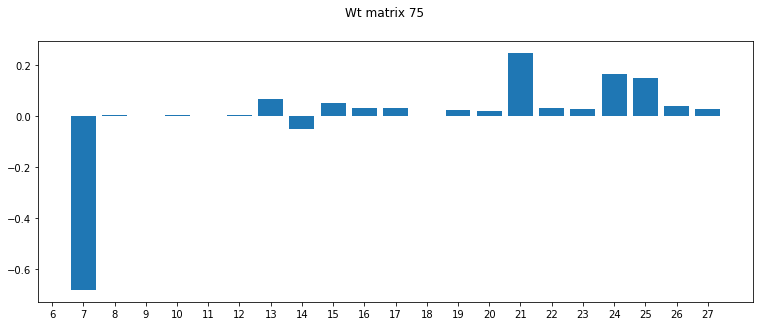

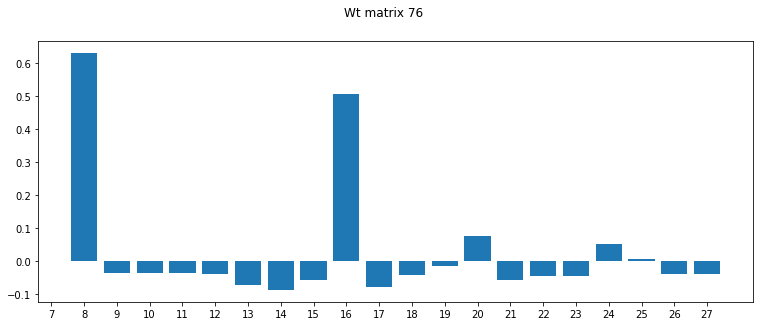

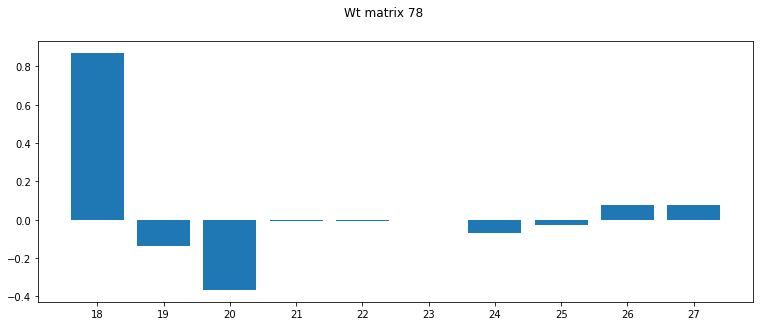

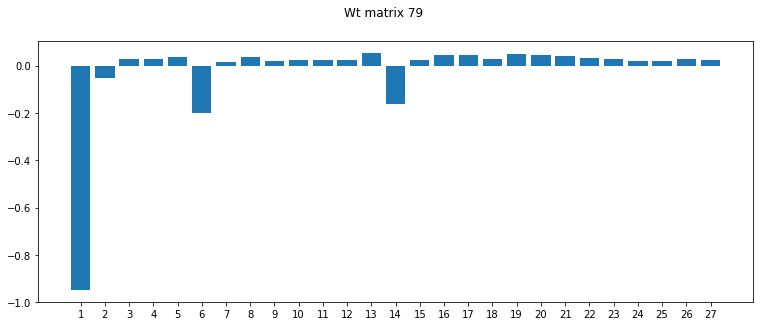

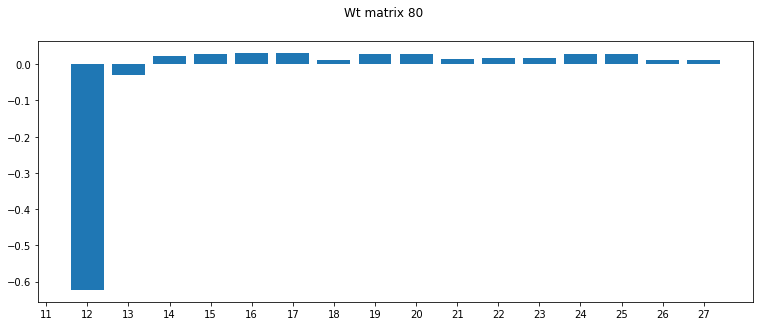

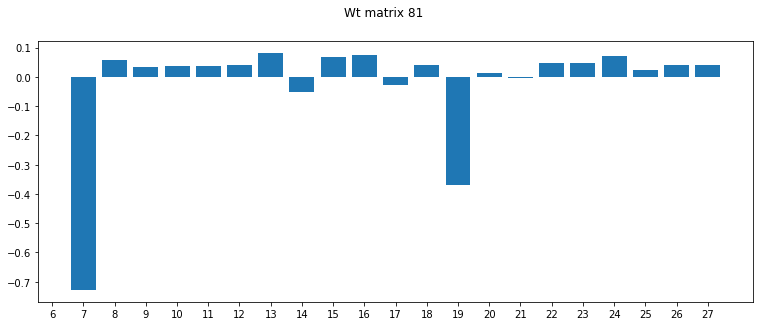

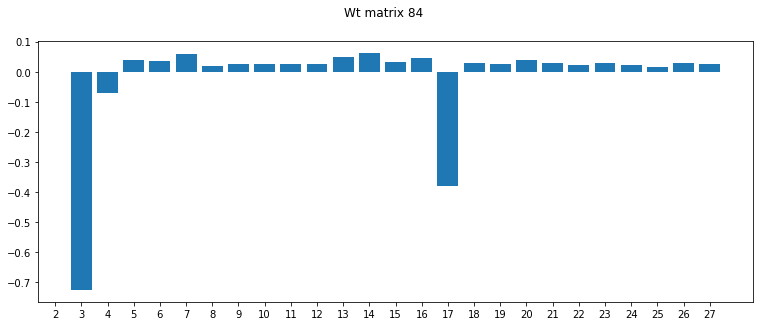

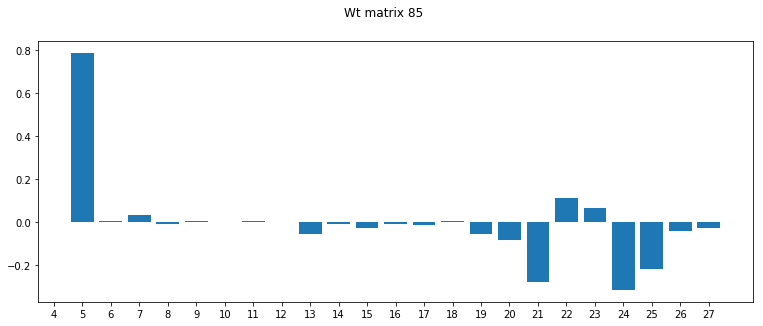

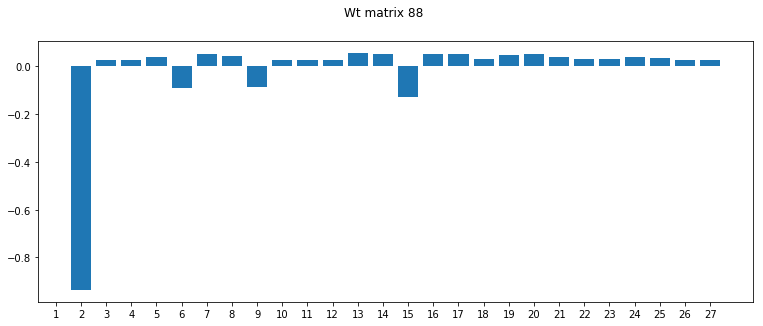

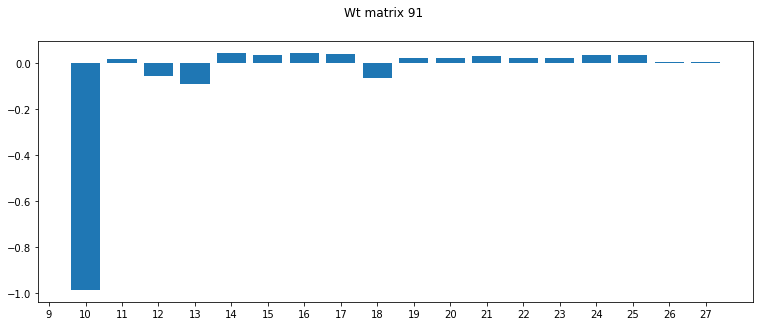

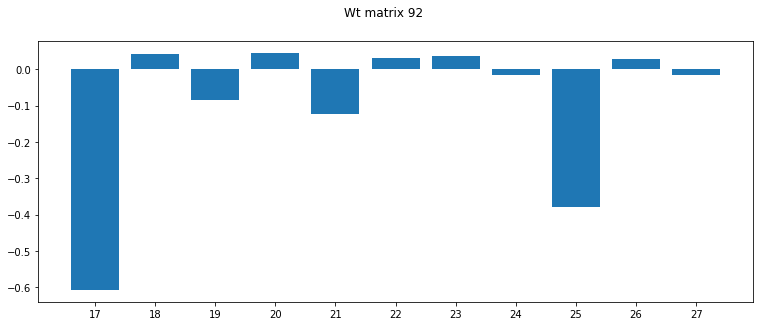

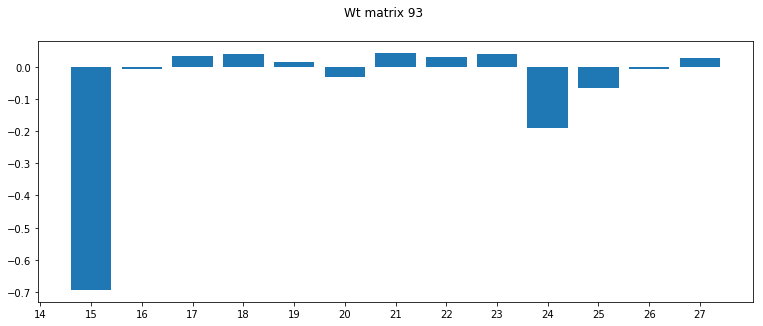

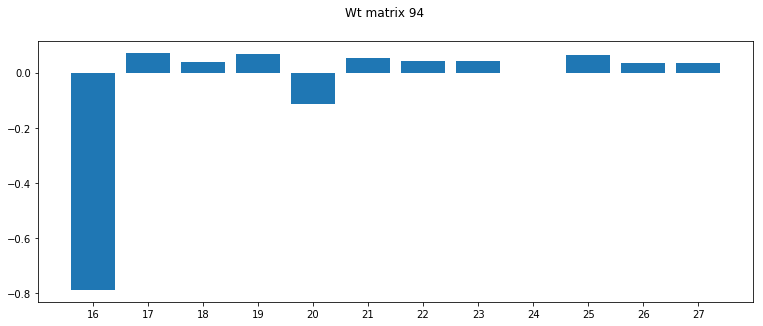

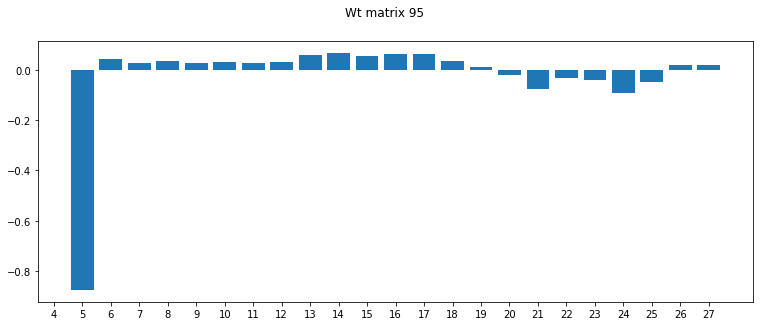

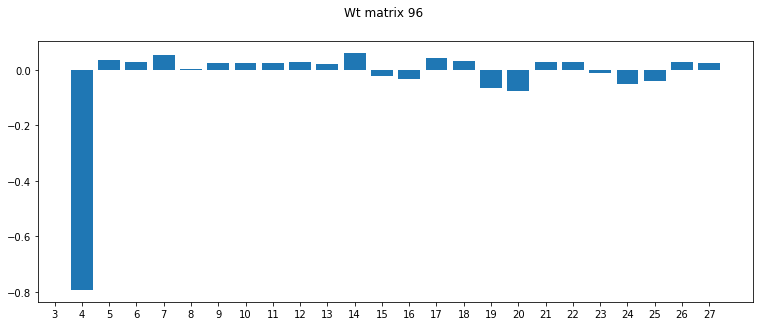

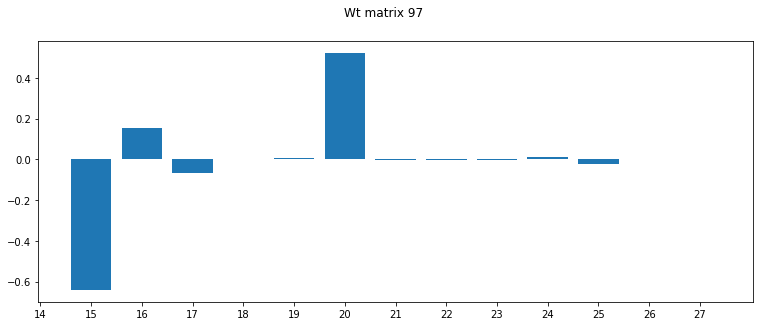

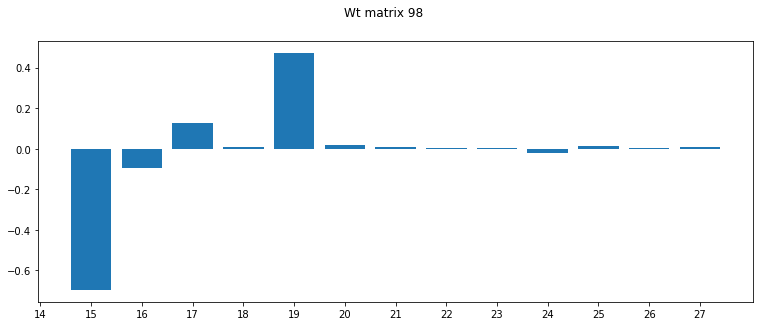

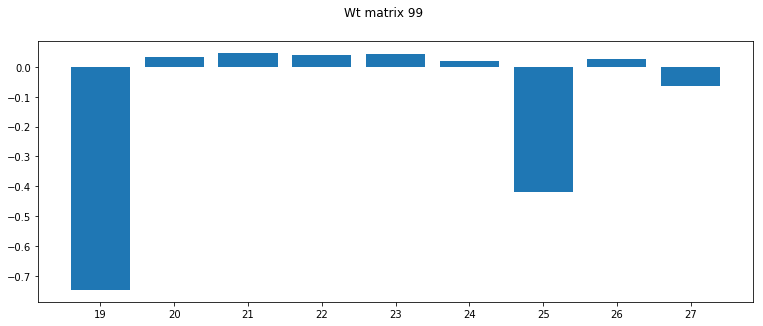

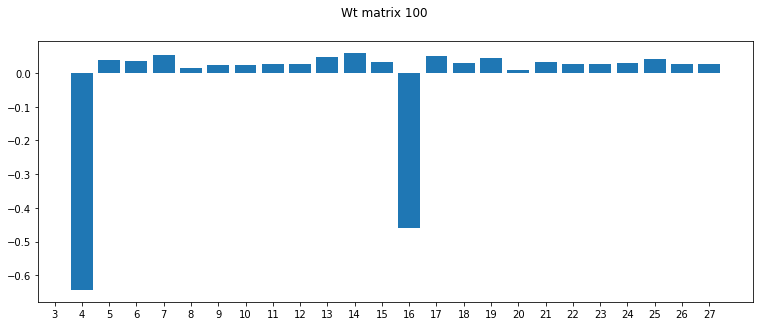

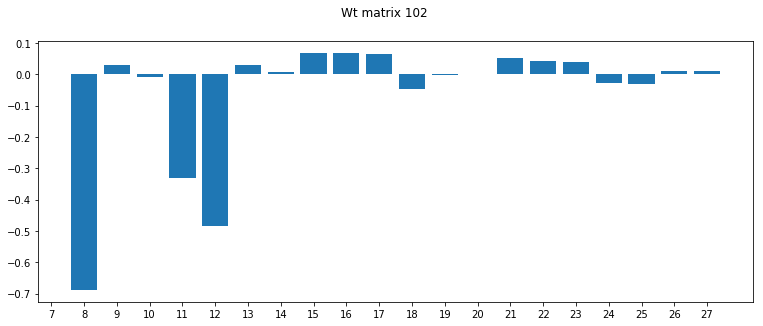

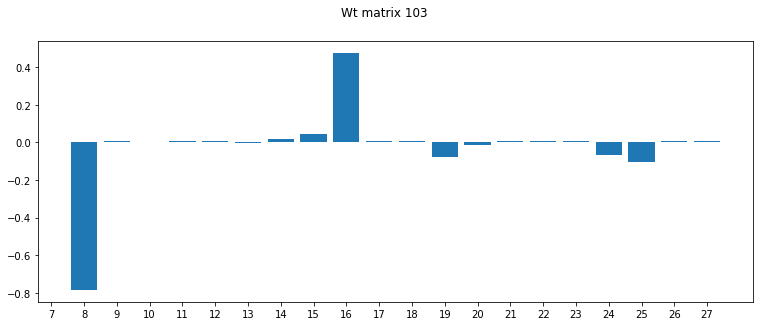

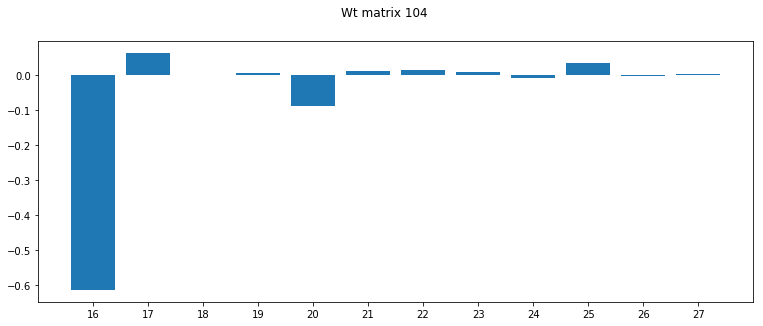

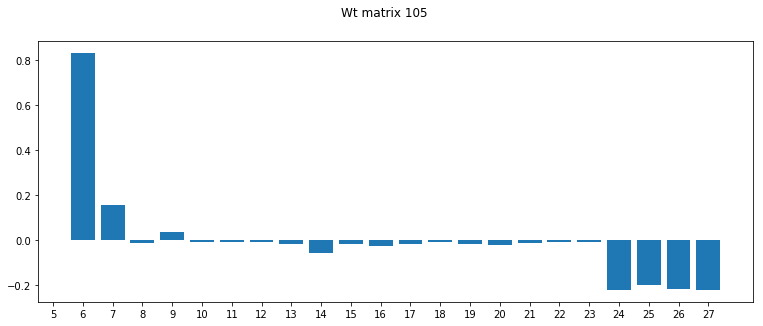

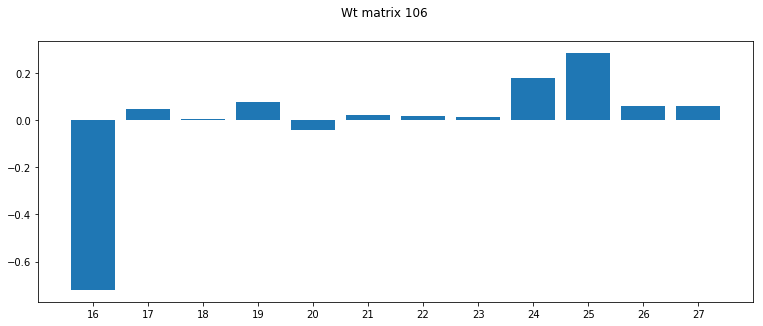

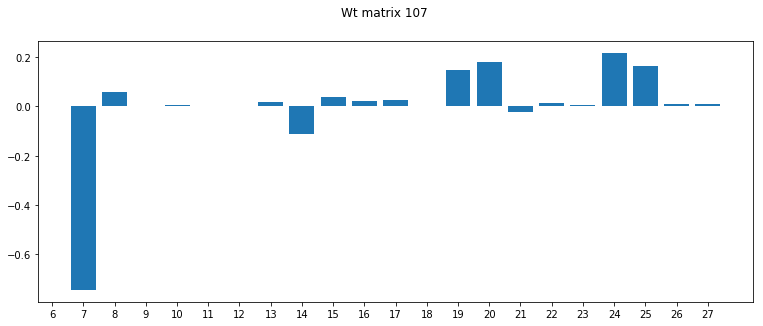

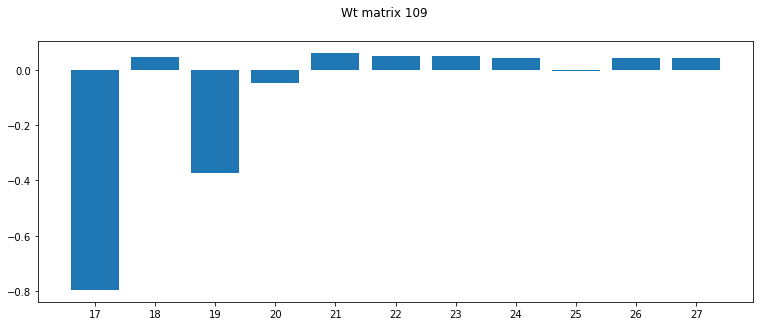

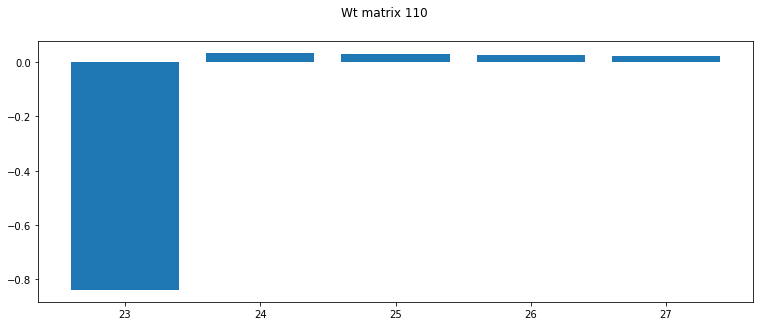

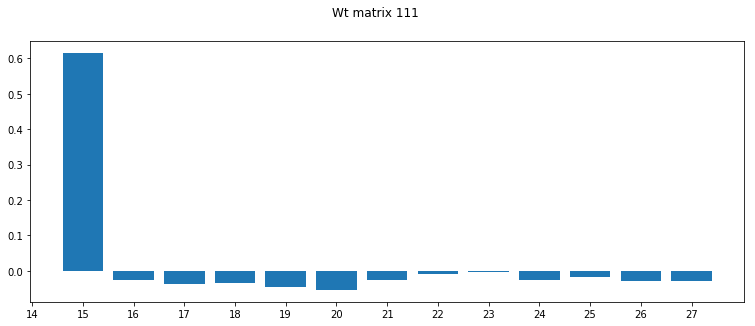

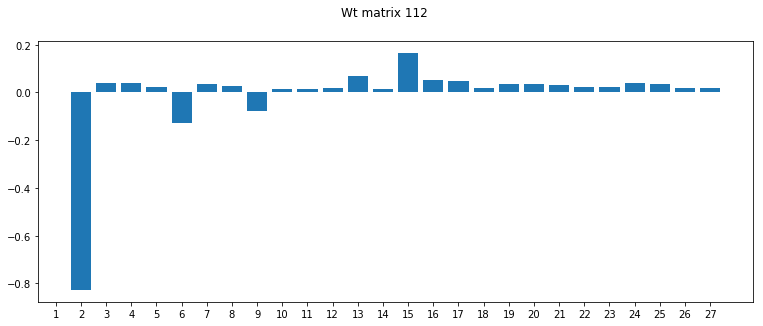

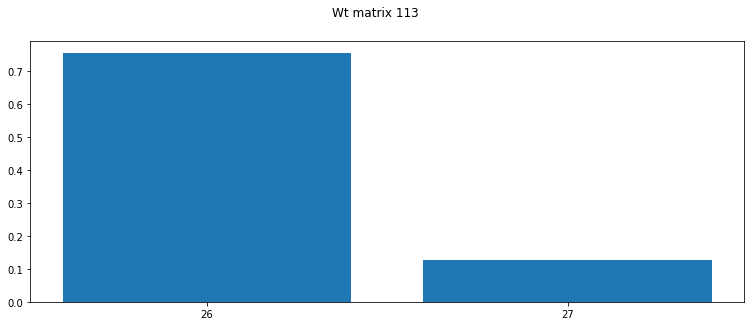

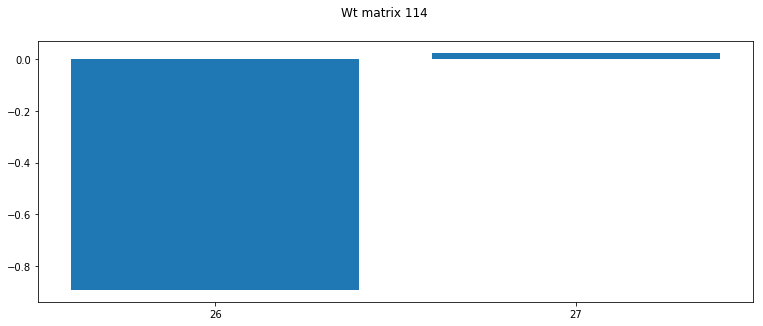

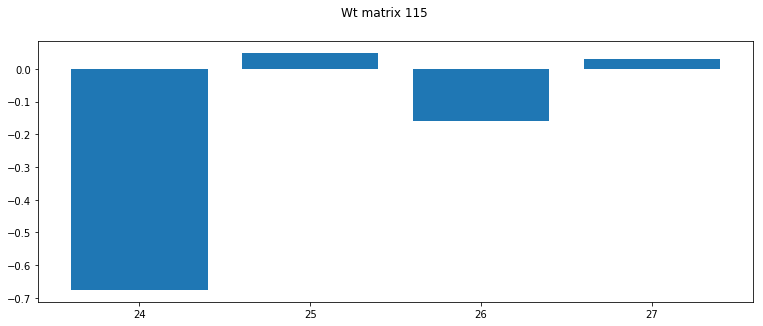

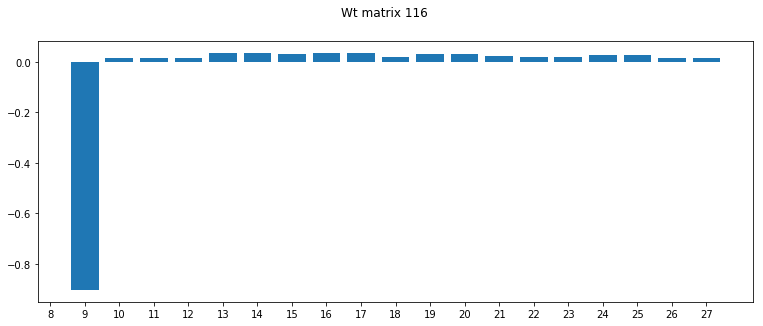

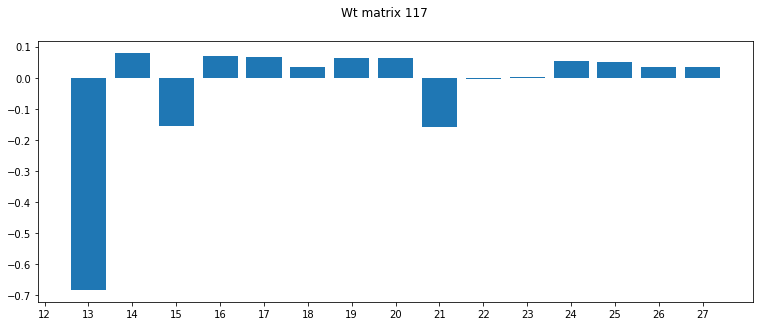

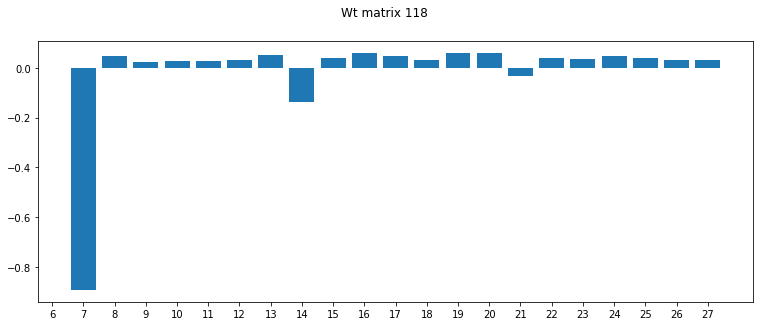

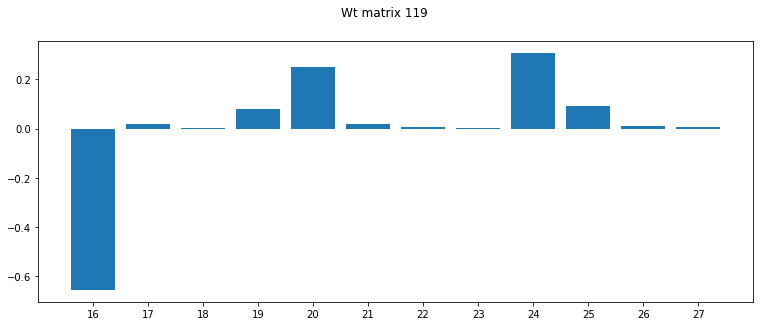

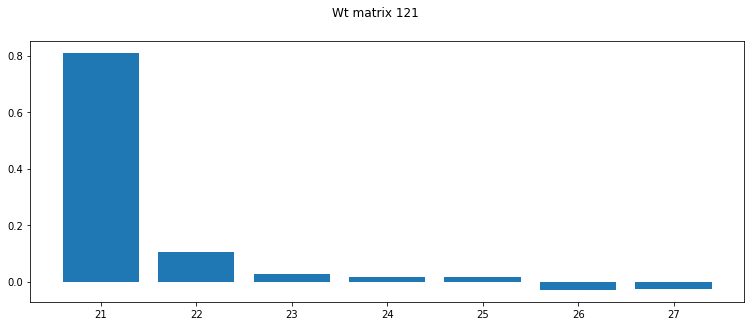

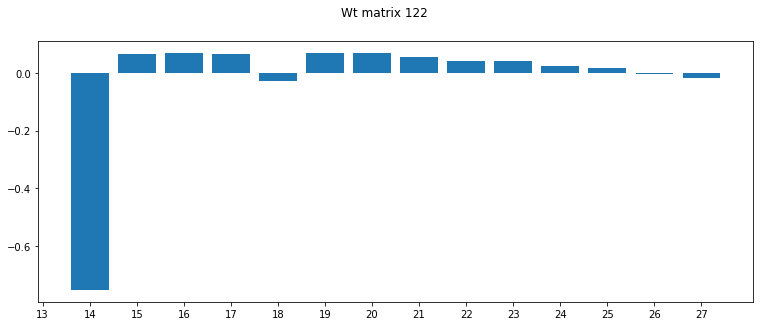

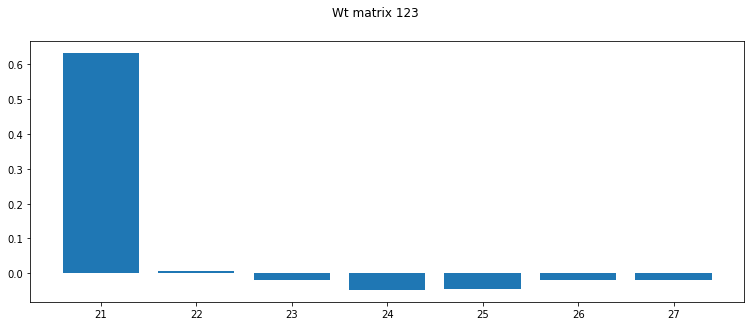

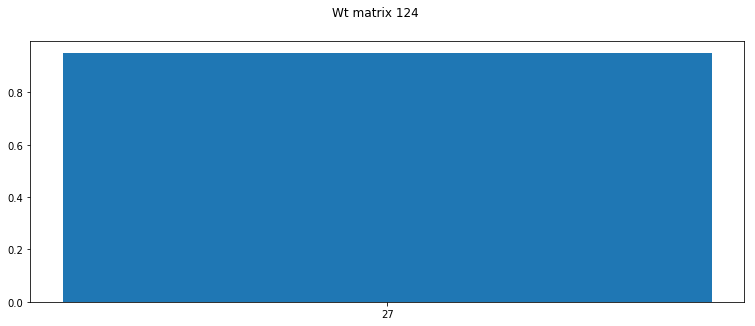

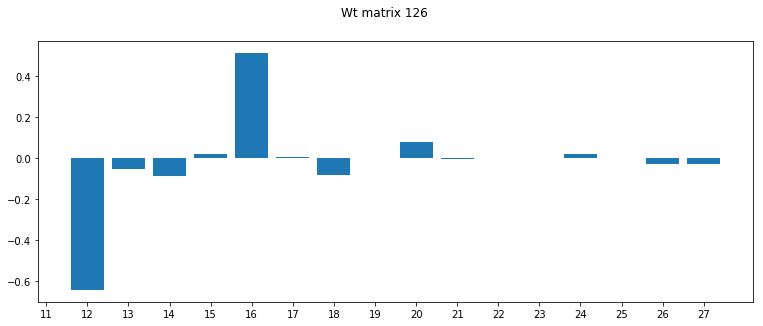

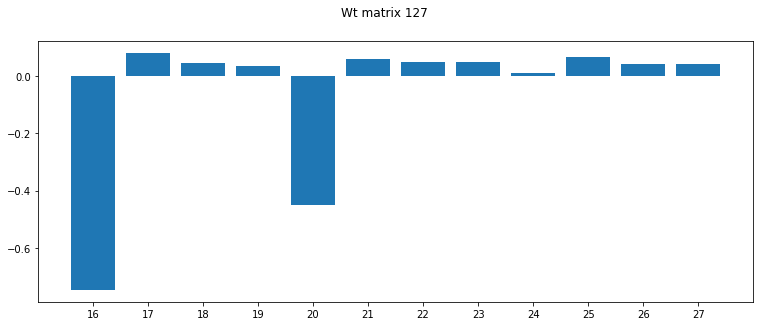

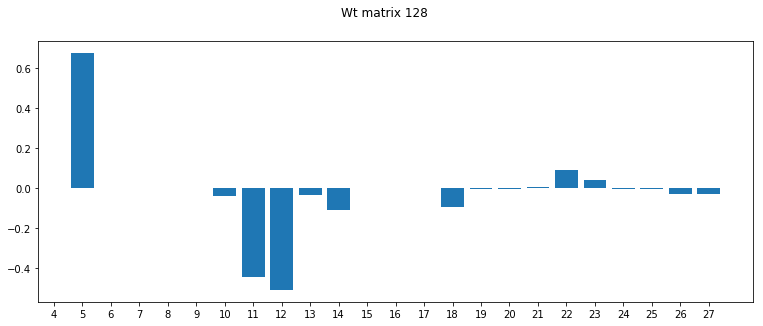

In [13]:
plot_sm_fnc(scorrs, wts_stdz)

| _ | _ |
| :-------------- | :--------: |
| <p style="text-align: left;"> Number of Weight matrices with spatial correlations >0.35 for two or more spatial components | 22 |
| <p style="text-align: left;"> Number of selected weights with at least partially correct FNC's | 20 (91%) |
| <p style="text-align: left;"> Number of selected weights with fully correct FNC's | 10 (45%) |
| <p style="text-align: left;"> Number of unique fully inaccurate FNC's | 1 |
| <p style="text-align: left;"> Number of accurately selected components | 10 (62.5%) |
| <p style="text-align: left;"> Number of inaccurate FNC components | 6 (37.5%) |
| <p style="text-align: left;"> Number of connected components represented | 10 of 14 (71%) | 